In [1]:
import math
import random
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple

import torch
from torch import Tensor, nn
from timm import create_model

In [2]:
class DetrFrozenBatchNorm2d(nn.Module):
    """
    BatchNorm2d where the batch statistics and the affine parameters are fixed.
    Copy-paste from torchvision.misc.ops with added eps before rqsrt, without which any other models than
    torchvision.models.resnet[18,34,50,101] produce nans.
    """

    def __init__(self, n):
        super().__init__()
        self.register_buffer("weight", torch.ones(n))
        self.register_buffer("bias", torch.zeros(n))
        self.register_buffer("running_mean", torch.zeros(n))
        self.register_buffer("running_var", torch.ones(n))

    def _load_from_state_dict(
        self, state_dict, prefix, local_metadata, strict, missing_keys, unexpected_keys, error_msgs
    ):
        num_batches_tracked_key = prefix + "num_batches_tracked"
        if num_batches_tracked_key in state_dict:
            del state_dict[num_batches_tracked_key]

        super()._load_from_state_dict(
            state_dict, prefix, local_metadata, strict, missing_keys, unexpected_keys, error_msgs
        )

    def forward(self, x):
        # move reshapes to the beginning
        # to make it user-friendly
        weight = self.weight.reshape(1, -1, 1, 1)
        bias = self.bias.reshape(1, -1, 1, 1)
        running_var = self.running_var.reshape(1, -1, 1, 1)
        running_mean = self.running_mean.reshape(1, -1, 1, 1)
        epsilon = 1e-5
        scale = weight * (running_var + epsilon).rsqrt()
        bias = bias - running_mean * scale
        return x * scale + bias

In [3]:
def replace_batch_norm(m, name=""):
    for attr_str in dir(m):
        target_attr = getattr(m, attr_str)
        if isinstance(target_attr, nn.BatchNorm2d):
            frozen = DetrFrozenBatchNorm2d(target_attr.num_features)
            bn = getattr(m, attr_str)
            frozen.weight.data.copy_(bn.weight)
            frozen.bias.data.copy_(bn.bias)
            frozen.running_mean.data.copy_(bn.running_mean)
            frozen.running_var.data.copy_(bn.running_var)
            setattr(m, attr_str, frozen)
    for n, ch in m.named_children():
        replace_batch_norm(ch, n)

In [4]:
class DetrConvEncoder(nn.Module):
    """
    Convolutional backbone, using either the AutoBackbone API or one from the timm library.
    nn.BatchNorm2d layers are replaced by DetrFrozenBatchNorm2d as defined above.
    """

    def __init__(self, use_timm_backbone, dilation, backbone, use_pretrained_backbone, 
                 num_channels, backbone_config,):
        super().__init__()

        self.use_timm_backbone = use_timm_backbone

        if use_timm_backbone:
            #requires_backends(self, ["timm"])
            kwargs = {}
            if dilation:
                kwargs["output_stride"] = 16
            backbone1 = create_model(
                backbone,
                pretrained=use_pretrained_backbone,
                features_only=True,
                out_indices=(1, 2, 3, 4),
                in_chans=num_channels,
                **kwargs,
            )
        else:
            backbone = AutoBackbone.from_config(backbone_config)

        # replace batch norm by frozen batch norm
        with torch.no_grad():
            replace_batch_norm(backbone1)
        self.model = backbone1
        self.intermediate_channel_sizes = (
            self.model.feature_info.channels() if use_timm_backbone else self.model.channels
        )

        backbone_model_type = backbone if use_timm_backbone else backbone_config.model_type
        if "resnet" in backbone_model_type:
            for name, parameter in self.model.named_parameters():
                if use_timm_backbone:
                    if "layer2" not in name and "layer3" not in name and "layer4" not in name:
                        parameter.requires_grad_(False)
                else:
                    if "stage.1" not in name and "stage.2" not in name and "stage.3" not in name:
                        parameter.requires_grad_(False)

    def forward(self, pixel_values: torch.Tensor, pixel_mask: torch.Tensor):
        # send pixel_values through the model to get list of feature maps
        features = self.model(pixel_values) if self.use_timm_backbone else self.model(pixel_values).feature_maps

        out = []
        for feature_map in features:
            # downsample pixel_mask to match shape of corresponding feature_map
            mask = nn.functional.interpolate(pixel_mask[None].float(), size=feature_map.shape[-2:]).to(torch.bool)[0]
            out.append((feature_map, mask))
        return out

In [5]:
class DetrConvModel(nn.Module):
    """
    This module adds 2D position embeddings to all intermediate feature maps of the convolutional encoder.
    """

    def __init__(self, conv_encoder, position_embedding):
        super().__init__()
        self.conv_encoder = conv_encoder
        self.position_embedding = position_embedding

    def forward(self, pixel_values, pixel_mask):
        # send pixel_values and pixel_mask through backbone to get list of (feature_map, pixel_mask) tuples
        out = self.conv_encoder(pixel_values, pixel_mask)
        pos = []
        for feature_map, mask in out:
            # position encoding
            pos.append(self.position_embedding(feature_map, mask).to(feature_map.dtype))

        return out, pos

In [6]:
def _expand_mask(mask: torch.Tensor, dtype: torch.dtype, target_len: Optional[int] = None):
    """
    Expands attention_mask from `[batch_size, seq_len]` to `[batch_size, 1, target_seq_len, source_seq_len]`.
    """
    batch_size, source_len = mask.size()
    target_len = target_len if target_len is not None else source_len

    expanded_mask = mask[:, None, None, :].expand(batch_size, 1, target_len, source_len).to(dtype)

    inverted_mask = 1.0 - expanded_mask

    return inverted_mask.masked_fill(inverted_mask.bool(), torch.finfo(dtype).min)

In [7]:
class DetrSinePositionEmbedding(nn.Module):
    """
    This is a more standard version of the position embedding, very similar to the one used by the Attention is all you
    need paper, generalized to work on images.
    """

    def __init__(self, embedding_dim=64, temperature=10000, normalize=False, scale=None):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.temperature = temperature
        self.normalize = normalize
        if scale is not None and normalize is False:
            raise ValueError("normalize should be True if scale is passed")
        if scale is None:
            scale = 2 * math.pi
        self.scale = scale

    def forward(self, pixel_values, pixel_mask):
        if pixel_mask is None:
            raise ValueError("No pixel mask provided")
        y_embed = pixel_mask.cumsum(1, dtype=torch.float32)
        x_embed = pixel_mask.cumsum(2, dtype=torch.float32)
        if self.normalize:
            y_embed = y_embed / (y_embed[:, -1:, :] + 1e-6) * self.scale
            x_embed = x_embed / (x_embed[:, :, -1:] + 1e-6) * self.scale

        dim_t = torch.arange(self.embedding_dim, dtype=torch.float32, device=pixel_values.device)
        dim_t = self.temperature ** (2 * torch.div(dim_t, 2, rounding_mode="floor") / self.embedding_dim)

        pos_x = x_embed[:, :, :, None] / dim_t
        pos_y = y_embed[:, :, :, None] / dim_t
        pos_x = torch.stack((pos_x[:, :, :, 0::2].sin(), pos_x[:, :, :, 1::2].cos()), dim=4).flatten(3)
        pos_y = torch.stack((pos_y[:, :, :, 0::2].sin(), pos_y[:, :, :, 1::2].cos()), dim=4).flatten(3)
        pos = torch.cat((pos_y, pos_x), dim=3).permute(0, 3, 1, 2)
        return pos

In [8]:
class DetrLearnedPositionEmbedding(nn.Module):
    """
    This module learns positional embeddings up to a fixed maximum size.
    """

    def __init__(self, embedding_dim=256):
        super().__init__()
        self.row_embeddings = nn.Embedding(50, embedding_dim)
        self.column_embeddings = nn.Embedding(50, embedding_dim)

    def forward(self, pixel_values, pixel_mask=None):
        height, width = pixel_values.shape[-2:]
        width_values = torch.arange(width, device=pixel_values.device)
        height_values = torch.arange(height, device=pixel_values.device)
        x_emb = self.column_embeddings(width_values)
        y_emb = self.row_embeddings(height_values)
        pos = torch.cat([x_emb.unsqueeze(0).repeat(height, 1, 1), y_emb.unsqueeze(1).repeat(1, width, 1)], dim=-1)
        pos = pos.permute(2, 0, 1)
        pos = pos.unsqueeze(0)
        pos = pos.repeat(pixel_values.shape[0], 1, 1, 1)
        return pos


In [9]:
def build_position_encoding(d_model, position_embedding_type):
    n_steps = d_model // 2
    if position_embedding_type == "sine":
        # TODO find a better way of exposing other arguments
        position_embedding = DetrSinePositionEmbedding(n_steps, normalize=True)
    elif position_embedding_type == "learned":
        position_embedding = DetrLearnedPositionEmbedding(n_steps)
    else:
        raise ValueError(f"Not supported {position_embedding_type}")

    return position_embedding


In [10]:
class DetrAttention(nn.Module):
    """
    Multi-headed attention from 'Attention Is All You Need' paper.
    Here, we add position embeddings to the queries and keys (as explained in the DETR paper).
    """

    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        dropout: float = 0.0,
        is_decoder: bool = False,
        bias: bool = True,
    ):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = embed_dim // num_heads
        if self.head_dim * num_heads != self.embed_dim:
            raise ValueError(
                f"embed_dim must be divisible by num_heads (got `embed_dim`: {self.embed_dim} and `num_heads`:"
                f" {num_heads})."
            )
        self.scaling = self.head_dim**-0.5

        self.k_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.v_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.q_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.out_proj = nn.Linear(embed_dim, embed_dim, bias=bias)

    def _shape(self, tensor: torch.Tensor, seq_len: int, batch_size: int):
        return tensor.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2).contiguous()

    def with_pos_embed(self, tensor: torch.Tensor, position_embeddings: Optional[Tensor]):
        return tensor if position_embeddings is None else tensor + position_embeddings

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        position_embeddings: Optional[torch.Tensor] = None,
        key_value_states: Optional[torch.Tensor] = None,
        key_value_position_embeddings: Optional[torch.Tensor] = None,
        output_attentions: bool = False,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
        """Input shape: Batch x Time x Channel"""

        # if key_value_states are provided this layer is used as a cross-attention layer
        # for the decoder
        is_cross_attention = key_value_states is not None
        batch_size, target_len, embed_dim = hidden_states.size()

        # add position embeddings to the hidden states before projecting to queries and keys
        if position_embeddings is not None:
            hidden_states_original = hidden_states
            hidden_states = self.with_pos_embed(hidden_states, position_embeddings)

        # add key-value position embeddings to the key value states
        if key_value_position_embeddings is not None:
            key_value_states_original = key_value_states
            key_value_states = self.with_pos_embed(key_value_states, key_value_position_embeddings)

        # get query proj
        query_states = self.q_proj(hidden_states) * self.scaling
        # get key, value proj
        if is_cross_attention:
            # cross_attentions
            key_states = self._shape(self.k_proj(key_value_states), -1, batch_size)
            value_states = self._shape(self.v_proj(key_value_states_original), -1, batch_size)
        else:
            # self_attention
            key_states = self._shape(self.k_proj(hidden_states), -1, batch_size)
            value_states = self._shape(self.v_proj(hidden_states_original), -1, batch_size)

        proj_shape = (batch_size * self.num_heads, -1, self.head_dim)
        query_states = self._shape(query_states, target_len, batch_size).view(*proj_shape)
        key_states = key_states.view(*proj_shape)
        value_states = value_states.view(*proj_shape)

        source_len = key_states.size(1)

        attn_weights = torch.bmm(query_states, key_states.transpose(1, 2))

        if attn_weights.size() != (batch_size * self.num_heads, target_len, source_len):
            raise ValueError(
                f"Attention weights should be of size {(batch_size * self.num_heads, target_len, source_len)}, but is"
                f" {attn_weights.size()}"
            )

        if attention_mask is not None:
            if attention_mask.size() != (batch_size, 1, target_len, source_len):
                raise ValueError(
                    f"Attention mask should be of size {(batch_size, 1, target_len, source_len)}, but is"
                    f" {attention_mask.size()}"
                )
            attn_weights = attn_weights.view(batch_size, self.num_heads, target_len, source_len) + attention_mask
            attn_weights = attn_weights.view(batch_size * self.num_heads, target_len, source_len)

        attn_weights = nn.functional.softmax(attn_weights, dim=-1)

        if output_attentions:
            # this operation is a bit awkward, but it's required to
            # make sure that attn_weights keeps its gradient.
            # In order to do so, attn_weights have to reshaped
            # twice and have to be reused in the following
            attn_weights_reshaped = attn_weights.view(batch_size, self.num_heads, target_len, source_len)
            attn_weights = attn_weights_reshaped.view(batch_size * self.num_heads, target_len, source_len)
        else:
            attn_weights_reshaped = None

        attn_probs = nn.functional.dropout(attn_weights, p=self.dropout, training=self.training)

        attn_output = torch.bmm(attn_probs, value_states)

        if attn_output.size() != (batch_size * self.num_heads, target_len, self.head_dim):
            raise ValueError(
                f"`attn_output` should be of size {(batch_size, self.num_heads, target_len, self.head_dim)}, but is"
                f" {attn_output.size()}"
            )

        attn_output = attn_output.view(batch_size, self.num_heads, target_len, self.head_dim)
        attn_output = attn_output.transpose(1, 2)
        attn_output = attn_output.reshape(batch_size, target_len, embed_dim)

        attn_output = self.out_proj(attn_output)

        return attn_output, attn_weights_reshaped

In [11]:
class DetrEncoderLayer(nn.Module):
    def __init__(self, d_model, encoder_attention_heads, attention_dropout, activation_dropout, dropout, encoder_ffn_dim):
        super().__init__()
        self.embed_dim = d_model
        self.self_attn = DetrAttention(
            embed_dim=self.embed_dim,
            num_heads=encoder_attention_heads,
            dropout=attention_dropout,
        )
        self.self_attn_layer_norm = nn.LayerNorm(self.embed_dim)
        self.dropout = dropout
        self.activation_fn = nn.GELU()
        self.activation_dropout = activation_dropout
        self.fc1 = nn.Linear(self.embed_dim, encoder_ffn_dim)
        self.fc2 = nn.Linear(encoder_ffn_dim, self.embed_dim)
        self.final_layer_norm = nn.LayerNorm(self.embed_dim)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: torch.Tensor,
        position_embeddings: torch.Tensor = None,
        output_attentions: bool = False,
    ):
        """
        Args:
            hidden_states (`torch.FloatTensor`): input to the layer of shape `(seq_len, batch, embed_dim)`
            attention_mask (`torch.FloatTensor`): attention mask of size
                `(batch, 1, target_len, source_len)` where padding elements are indicated by very large negative
                values.
            position_embeddings (`torch.FloatTensor`, *optional*): position embeddings, to be added to hidden_states.
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
        """
        residual = hidden_states
        hidden_states, attn_weights = self.self_attn(
            hidden_states=hidden_states,
            attention_mask=attention_mask,
            position_embeddings=position_embeddings,
            output_attentions=output_attentions,
        )

        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        hidden_states = residual + hidden_states
        hidden_states = self.self_attn_layer_norm(hidden_states)

        residual = hidden_states
        hidden_states = self.activation_fn(self.fc1(hidden_states))
        hidden_states = nn.functional.dropout(hidden_states, p=self.activation_dropout, training=self.training)

        hidden_states = self.fc2(hidden_states)
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)

        hidden_states = residual + hidden_states
        hidden_states = self.final_layer_norm(hidden_states)

        if self.training:
            if torch.isinf(hidden_states).any() or torch.isnan(hidden_states).any():
                clamp_value = torch.finfo(hidden_states.dtype).max - 1000
                hidden_states = torch.clamp(hidden_states, min=-clamp_value, max=clamp_value)

        outputs = (hidden_states,)

        if output_attentions:
            outputs += (attn_weights,)

        return outputs


In [12]:
class DetrDecoderLayer(nn.Module):
    def __init__(self, d_model, decoder_attention_heads, attention_dropout, activation_dropout, dropout, decoder_ffn_dim):
        super().__init__()
        self.embed_dim = d_model

        self.self_attn = DetrAttention(
            embed_dim=self.embed_dim,
            num_heads=decoder_attention_heads,
            dropout=attention_dropout,
            is_decoder=True,
        )
        self.dropout = dropout
        self.activation_fn = nn.GELU()
        self.activation_dropout = activation_dropout

        self.self_attn_layer_norm = nn.LayerNorm(self.embed_dim)
        self.encoder_attn = DetrAttention(
            self.embed_dim,
            decoder_attention_heads,
            dropout=attention_dropout,
            is_decoder=True,
        )
        self.encoder_attn_layer_norm = nn.LayerNorm(self.embed_dim)
        self.fc1 = nn.Linear(self.embed_dim, decoder_ffn_dim)
        self.fc2 = nn.Linear(decoder_ffn_dim, self.embed_dim)
        self.final_layer_norm = nn.LayerNorm(self.embed_dim)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        position_embeddings: Optional[torch.Tensor] = None,
        query_position_embeddings: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = False,
    ):
        """
        Args:
            hidden_states (`torch.FloatTensor`): input to the layer of shape `(seq_len, batch, embed_dim)`
            attention_mask (`torch.FloatTensor`): attention mask of size
                `(batch, 1, target_len, source_len)` where padding elements are indicated by very large negative
                values.
            position_embeddings (`torch.FloatTensor`, *optional*):
                position embeddings that are added to the queries and keys
            in the cross-attention layer.
            query_position_embeddings (`torch.FloatTensor`, *optional*):
                position embeddings that are added to the queries and keys
            in the self-attention layer.
            encoder_hidden_states (`torch.FloatTensor`):
                cross attention input to the layer of shape `(seq_len, batch, embed_dim)`
            encoder_attention_mask (`torch.FloatTensor`): encoder attention mask of size
                `(batch, 1, target_len, source_len)` where padding elements are indicated by very large negative
                values.
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
        """
        residual = hidden_states

        # Self Attention
        hidden_states, self_attn_weights = self.self_attn(
            hidden_states=hidden_states,
            position_embeddings=query_position_embeddings,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
        )

        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        hidden_states = residual + hidden_states
        hidden_states = self.self_attn_layer_norm(hidden_states)

        # Cross-Attention Block
        cross_attn_weights = None
        if encoder_hidden_states is not None:
            residual = hidden_states

            hidden_states, cross_attn_weights = self.encoder_attn(
                hidden_states=hidden_states,
                position_embeddings=query_position_embeddings,
                key_value_states=encoder_hidden_states,
                attention_mask=encoder_attention_mask,
                key_value_position_embeddings=position_embeddings,
                output_attentions=output_attentions,
            )

            hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
            hidden_states = residual + hidden_states
            hidden_states = self.encoder_attn_layer_norm(hidden_states)

        # Fully Connected
        residual = hidden_states
        hidden_states = self.activation_fn(self.fc1(hidden_states))
        hidden_states = nn.functional.dropout(hidden_states, p=self.activation_dropout, training=self.training)
        hidden_states = self.fc2(hidden_states)
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        hidden_states = residual + hidden_states
        hidden_states = self.final_layer_norm(hidden_states)

        outputs = (hidden_states,)

        if output_attentions:
            outputs += (self_attn_weights, cross_attn_weights)

        return outputs

In [13]:
class DetrClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, input_dim: int, inner_dim: int, num_classes: int, pooler_dropout: float):
        super().__init__()
        self.dense = nn.Linear(input_dim, inner_dim)
        self.dropout = nn.Dropout(p=pooler_dropout)
        self.out_proj = nn.Linear(inner_dim, num_classes)

    def forward(self, hidden_states: torch.Tensor):
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.dense(hidden_states)
        hidden_states = torch.tanh(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.out_proj(hidden_states)
        return hidden_states

In [14]:
class DetrEncoder(nn.Module):
    """
    Transformer encoder consisting of *config.encoder_layers* self attention layers. Each layer is a
    [`DetrEncoderLayer`].
    The encoder updates the flattened feature map through multiple self-attention layers.
    Small tweak for DETR:
    - position_embeddings are added to the forward pass.
    Args:
        config: DetrConfig
    """

    def __init__(self, encoder_layers, encoder_layerdrop, d_model, encoder_attention_heads, 
                 attention_dropout, activation_dropout, dropout, encoder_ffn_dim, 
                 output_attentions, output_hidden_states, use_return_dict):
        super().__init__()

        self.dropout = dropout
        self.layerdrop = encoder_layerdrop

        self.layers = nn.ModuleList([DetrEncoderLayer(d_model, encoder_attention_heads, 
                 attention_dropout, activation_dropout, dropout, encoder_ffn_dim) for _ in range(encoder_layers)])

        # in the original DETR, no layernorm is used at the end of the encoder, as "normalize_before" is set to False by default

        # Initialize weights and apply final processing
        
        self.output_attentions = output_attentions
        self.output_hidden_states = output_hidden_states
        self.use_return_dict = use_return_dict

    def forward(
        self,
        inputs_embeds=None,
        attention_mask=None,
        position_embeddings=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        Args:
            inputs_embeds (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`):
                Flattened feature map (output of the backbone + projection layer) that is passed to the encoder.
            attention_mask (`torch.Tensor` of shape `(batch_size, sequence_length)`, *optional*):
                Mask to avoid performing attention on padding pixel features. Mask values selected in `[0, 1]`:
                - 1 for pixel features that are real (i.e. **not masked**),
                - 0 for pixel features that are padding (i.e. **masked**).
                [What are attention masks?](../glossary#attention-mask)
            position_embeddings (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`):
                Position embeddings that are added to the queries and keys in each self-attention layer.
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
            output_hidden_states (`bool`, *optional*):
                Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors
                for more detail.
            return_dict (`bool`, *optional*):
                Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
        """
        output_attentions = output_attentions if output_attentions is not None else self.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.use_return_dict

        hidden_states = inputs_embeds
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)

        # expand attention_mask
        if attention_mask is not None:
            # [batch_size, seq_len] -> [batch_size, 1, target_seq_len, source_seq_len]
            attention_mask = _expand_mask(attention_mask, inputs_embeds.dtype)

        encoder_states = () if output_hidden_states else None
        all_attentions = () if output_attentions else None
        for i, encoder_layer in enumerate(self.layers):
            if output_hidden_states:
                encoder_states = encoder_states + (hidden_states,)
            # add LayerDrop (see https://arxiv.org/abs/1909.11556 for description)
            dropout_probability = random.uniform(0, 1)
            if self.training and (dropout_probability < self.layerdrop):  # skip the layer
                layer_outputs = (None, None)
            else:
                # we add position_embeddings as extra input to the encoder_layer
                layer_outputs = encoder_layer(
                    hidden_states,
                    attention_mask,
                    position_embeddings=position_embeddings,
                    output_attentions=output_attentions,
                )

                hidden_states = layer_outputs[0]

            if output_attentions:
                all_attentions = all_attentions + (layer_outputs[1],)

        if output_hidden_states:
            encoder_states = encoder_states + (hidden_states,)

        if not return_dict:
            return tuple(v for v in [hidden_states, encoder_states, all_attentions] if v is not None)

In [15]:
class DetrDecoder(nn.Module):
    """
    Transformer decoder consisting of *config.decoder_layers* layers. Each layer is a [`DetrDecoderLayer`].
    The decoder updates the query embeddings through multiple self-attention and cross-attention layers.
    Some small tweaks for DETR:
    - position_embeddings and query_position_embeddings are added to the forward pass.
    - if self.config.auxiliary_loss is set to True, also returns a stack of activations from all decoding layers.
    Args:
        config: DetrConfig
    """

    def __init__(self, decoder_layers, decoder_layerdrop, d_model, decoder_attention_heads, 
                 attention_dropout, activation_dropout, dropout, decoder_ffn_dim, 
                 output_attentions, output_hidden_states, use_return_dict, auxiliary_loss):
        super().__init__()
        self.dropout = dropout
        self.layerdrop = decoder_layerdrop

        self.layers = nn.ModuleList([DetrDecoderLayer(d_model, decoder_attention_heads, 
                 attention_dropout, activation_dropout, dropout, decoder_ffn_dim) for _ in range(decoder_layers)])
        # in DETR, the decoder uses layernorm after the last decoder layer output
        self.layernorm = nn.LayerNorm(d_model)

        self.gradient_checkpointing = False
        # Initialize weights and apply final processing
        
        self.output_attentions = output_attentions
        self.output_hidden_states = output_hidden_states
        self.use_return_dict = use_return_dict
        self.auxiliary_loss = auxiliary_loss

    def forward(
        self,
        inputs_embeds=None,
        attention_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        position_embeddings=None,
        query_position_embeddings=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        Args:
            inputs_embeds (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`):
                The query embeddings that are passed into the decoder.
            attention_mask (`torch.Tensor` of shape `(batch_size, sequence_length)`, *optional*):
                Mask to avoid performing attention on certain queries. Mask values selected in `[0, 1]`:
                - 1 for queries that are **not masked**,
                - 0 for queries that are **masked**.
                [What are attention masks?](../glossary#attention-mask)
            encoder_hidden_states (`torch.FloatTensor` of shape `(batch_size, encoder_sequence_length, hidden_size)`, *optional*):
                Sequence of hidden-states at the output of the last layer of the encoder. Used in the cross-attention
                of the decoder.
            encoder_attention_mask (`torch.LongTensor` of shape `(batch_size, encoder_sequence_length)`, *optional*):
                Mask to avoid performing cross-attention on padding pixel_values of the encoder. Mask values selected
                in `[0, 1]`:
                - 1 for pixels that are real (i.e. **not masked**),
                - 0 for pixels that are padding (i.e. **masked**).
            position_embeddings (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`, *optional*):
                Position embeddings that are added to the queries and keys in each cross-attention layer.
            query_position_embeddings (`torch.FloatTensor` of shape `(batch_size, num_queries, hidden_size)`):
                , *optional*): Position embeddings that are added to the queries and keys in each self-attention layer.
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
            output_hidden_states (`bool`, *optional*):
                Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors
                for more detail.
            return_dict (`bool`, *optional*):
                Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
        """
        output_attentions = output_attentions if output_attentions is not None else self.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.use_return_dict

        if inputs_embeds is not None:
            hidden_states = inputs_embeds
            input_shape = inputs_embeds.size()[:-1]

        combined_attention_mask = None

        if attention_mask is not None and combined_attention_mask is not None:
            # [batch_size, seq_len] -> [batch_size, 1, target_seq_len, source_seq_len]
            combined_attention_mask = combined_attention_mask + _expand_mask(
                attention_mask, inputs_embeds.dtype, target_len=input_shape[-1]
            )

        # expand encoder attention mask
        if encoder_hidden_states is not None and encoder_attention_mask is not None:
            # [batch_size, seq_len] -> [batch_size, 1, target_seq_len, source_seq_len]
            encoder_attention_mask = _expand_mask(
                encoder_attention_mask, inputs_embeds.dtype, target_len=input_shape[-1]
            )

        # optional intermediate hidden states
        intermediate = () if self.auxiliary_loss else None

        # decoder layers
        all_hidden_states = () if output_hidden_states else None
        all_self_attns = () if output_attentions else None
        all_cross_attentions = () if (output_attentions and encoder_hidden_states is not None) else None

        for idx, decoder_layer in enumerate(self.layers):
            # add LayerDrop (see https://arxiv.org/abs/1909.11556 for description)
            if output_hidden_states:
                all_hidden_states += (hidden_states,)
            dropout_probability = random.uniform(0, 1)
            if self.training and (dropout_probability < self.layerdrop):
                continue

            if self.gradient_checkpointing and self.training:

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        return module(*inputs, output_attentions)

                    return custom_forward

                layer_outputs = torch.utils.checkpoint.checkpoint(
                    create_custom_forward(decoder_layer),
                    hidden_states,
                    combined_attention_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                    None,
                )
            else:
                layer_outputs = decoder_layer(
                    hidden_states,
                    attention_mask=combined_attention_mask,
                    position_embeddings=position_embeddings,
                    query_position_embeddings=query_position_embeddings,
                    encoder_hidden_states=encoder_hidden_states,
                    encoder_attention_mask=encoder_attention_mask,
                    output_attentions=output_attentions,
                )

            hidden_states = layer_outputs[0]

            if self.auxiliary_loss:
                hidden_states = self.layernorm(hidden_states)
                intermediate += (hidden_states,)

            if output_attentions:
                all_self_attns += (layer_outputs[1],)

                if encoder_hidden_states is not None:
                    all_cross_attentions += (layer_outputs[2],)

        # finally, apply layernorm
        hidden_states = self.layernorm(hidden_states)

        # add hidden states from the last decoder layer
        if output_hidden_states:
            all_hidden_states += (hidden_states,)

        # stack intermediate decoder activations
        if self.auxiliary_loss:
            intermediate = torch.stack(intermediate)

        if not return_dict:
            return tuple(
                v
                for v in [hidden_states, all_hidden_states, all_self_attns, all_cross_attentions, intermediate]
                if v is not None
            )


In [16]:
class DetrModel(nn.Module):
    def __init__(self, use_timm_backbone, dilation, backbone, use_pretrained_backbone, 
                 num_channels, backbone_config, d_model, num_queries, position_embedding_type, 
                 encoder_layers, decoder_layers, encoder_layerdrop, decoder_layerdrop, 
                 encoder_attention_heads, decoder_attention_heads, attention_dropout, 
                 activation_dropout, dropout, encoder_ffn_dim, decoder_ffn_dim, 
                 output_attentions, output_hidden_states, use_return_dict, auxiliary_loss):
        super().__init__()

        # Create backbone + positional encoding
        backbone = DetrConvEncoder(use_timm_backbone, dilation, backbone, use_pretrained_backbone, 
                 num_channels, backbone_config)
        position_embeddings = build_position_encoding(d_model, position_embedding_type)
        self.backbone = DetrConvModel(backbone, position_embeddings)

        # Create projection layer
        self.input_projection = nn.Conv2d(backbone.intermediate_channel_sizes[-1], d_model, kernel_size=1)

        self.query_position_embeddings = nn.Embedding(num_queries, d_model)

        self.encoder = DetrEncoder(encoder_layers, encoder_layerdrop, d_model, 
                 encoder_attention_heads, attention_dropout, activation_dropout, 
                 dropout, encoder_ffn_dim, output_attentions, output_hidden_states, 
                 use_return_dict)
        self.decoder = DetrDecoder(decoder_layers, decoder_layerdrop, d_model, 
                 decoder_attention_heads, attention_dropout, activation_dropout, 
                 dropout, decoder_ffn_dim, output_attentions, output_hidden_states, 
                 use_return_dict, auxiliary_loss)

        # Initialize weights and apply final processing
        
        self.output_attentions = output_attentions
        self.output_hidden_states = output_hidden_states
        self.use_return_dict = use_return_dict

    def get_encoder(self):
        return self.encoder

    def get_decoder(self):
        return self.decoder

    def freeze_backbone(self):
        for name, param in self.backbone.conv_encoder.model.named_parameters():
            param.requires_grad_(False)

    def unfreeze_backbone(self):
        for name, param in self.backbone.conv_encoder.model.named_parameters():
            param.requires_grad_(True)

    def forward(
        self,
        pixel_values,
        pixel_mask=None,
        decoder_attention_mask=None,
        encoder_outputs=None,
        inputs_embeds=None,
        decoder_inputs_embeds=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        Returns:
        Examples:
        ```python
        >>> from transformers import AutoImageProcessor, DetrModel
        >>> from PIL import Image
        >>> import requests
        >>> url = "http://images.cocodataset.org/val2017/000000039769.jpg"
        >>> image = Image.open(requests.get(url, stream=True).raw)
        >>> image_processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50")
        >>> model = DetrModel.from_pretrained("facebook/detr-resnet-50")
        >>> # prepare image for the model
        >>> inputs = image_processor(images=image, return_tensors="pt")
        >>> # forward pass
        >>> outputs = model(**inputs)
        >>> # the last hidden states are the final query embeddings of the Transformer decoder
        >>> # these are of shape (batch_size, num_queries, hidden_size)
        >>> last_hidden_states = outputs.last_hidden_state
        >>> list(last_hidden_states.shape)
        [1, 100, 256]
        ```"""
        output_attentions = output_attentions if output_attentions is not None else self.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.use_return_dict

        batch_size, num_channels, height, width = pixel_values.shape
        device = pixel_values.device

        if pixel_mask is None:
            pixel_mask = torch.ones(((batch_size, height, width)), device=device)

        # First, sent pixel_values + pixel_mask through Backbone to obtain the features
        # pixel_values should be of shape (batch_size, num_channels, height, width)
        # pixel_mask should be of shape (batch_size, height, width)     
        features, position_embeddings_list = self.backbone(pixel_values, pixel_mask)

        # get final feature map and downsampled mask
        feature_map, mask = features[-1]

        if mask is None:
            raise ValueError("Backbone does not return downsampled pixel mask")

        # Second, apply 1x1 convolution to reduce the channel dimension to d_model (256 by default)
        projected_feature_map = self.input_projection(feature_map)

        # Third, flatten the feature map + position embeddings of shape NxCxHxW to NxCxHW, and permute it to NxHWxC
        # In other words, turn their shape into (batch_size, sequence_length, hidden_size)
        flattened_features = projected_feature_map.flatten(2).permute(0, 2, 1)
        position_embeddings = position_embeddings_list[-1].flatten(2).permute(0, 2, 1)

        flattened_mask = mask.flatten(1)

        # Fourth, sent flattened_features + flattened_mask + position embeddings through encoder
        # flattened_features is a Tensor of shape (batch_size, heigth*width, hidden_size)
        # flattened_mask is a Tensor of shape (batch_size, heigth*width)
        
        if encoder_outputs is None:
            encoder_outputs = self.encoder(
                inputs_embeds=flattened_features,
                attention_mask=flattened_mask,
                position_embeddings=position_embeddings,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
                return_dict=return_dict,
            )
        # If the user passed a tuple for encoder_outputs, we wrap it in a BaseModelOutput when return_dict=True
        elif return_dict and not isinstance(encoder_outputs, BaseModelOutput):
            encoder_outputs = BaseModelOutput(
                last_hidden_state=encoder_outputs[0],
                hidden_states=encoder_outputs[1] if len(encoder_outputs) > 1 else None,
                attentions=encoder_outputs[2] if len(encoder_outputs) > 2 else None,
            )

        # Fifth, sent query embeddings + position embeddings through the decoder (which is conditioned on the encoder output)
        query_position_embeddings = self.query_position_embeddings.weight.unsqueeze(0).repeat(batch_size, 1, 1)
        queries = torch.zeros_like(query_position_embeddings)

        # decoder outputs consists of (dec_features, dec_hidden, dec_attn)
        decoder_outputs = self.decoder(
            inputs_embeds=queries,
            attention_mask=None,
            position_embeddings=position_embeddings,
            query_position_embeddings=query_position_embeddings,
            encoder_hidden_states=encoder_outputs[0],
            encoder_attention_mask=flattened_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        if not return_dict:
            return decoder_outputs + encoder_outputs


In [17]:
class DetrMLPPredictionHead(nn.Module):
    """
    Very simple multi-layer perceptron (MLP, also called FFN), used to predict the normalized center coordinates,
    height and width of a bounding box w.r.t. an image.
    Copied from https://github.com/facebookresearch/detr/blob/master/models/detr.py
    """

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.num_layers = num_layers
        h = [hidden_dim] * (num_layers - 1)
        self.layers = nn.ModuleList(nn.Linear(n, k) for n, k in zip([input_dim] + h, h + [output_dim]))

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = nn.functional.relu(layer(x)) if i < self.num_layers - 1 else layer(x)
        return x

In [18]:
class DetrForObjectDetection(nn.Module):
    def __init__(self, num_labels, use_timm_backbone, dilation, backbone, use_pretrained_backbone, 
                 num_channels, backbone_config, d_model, num_queries, position_embedding_type, 
                 encoder_layers, decoder_layers, encoder_layerdrop, decoder_layerdrop, 
                 encoder_attention_heads, decoder_attention_heads, attention_dropout, 
                 activation_dropout, dropout, encoder_ffn_dim, decoder_ffn_dim, 
                 output_attentions, output_hidden_states, use_return_dict, auxiliary_loss):
        super().__init__()

        # DETR encoder-decoder model
        self.model = DetrModel(use_timm_backbone, dilation, backbone, use_pretrained_backbone, 
                 num_channels, backbone_config, d_model, num_queries, position_embedding_type, 
                 encoder_layers, decoder_layers, encoder_layerdrop, decoder_layerdrop, 
                 encoder_attention_heads, decoder_attention_heads, attention_dropout, 
                 activation_dropout, dropout, encoder_ffn_dim, decoder_ffn_dim, 
                 output_attentions, output_hidden_states, use_return_dict, auxiliary_loss)

        # Object detection heads
        self.class_labels_classifier = nn.Linear(
            d_model, num_labels + 1
        )  # We add one for the "no object" class
        self.bbox_predictor = DetrMLPPredictionHead(
            input_dim=d_model, hidden_dim=d_model, output_dim=30, num_layers=3
        )

        # Initialize weights and apply final processing
        
        self.output_attentions = output_attentions
        self.output_hidden_states = output_hidden_states
        self.use_return_dict = use_return_dict
        self.flatten = nn.Flatten()

    # taken from https://github.com/facebookresearch/detr/blob/master/models/detr.py
    @torch.jit.unused
    def _set_aux_loss(self, outputs_class, outputs_coord):
        # this is a workaround to make torchscript happy, as torchscript
        # doesn't support dictionary with non-homogeneous values, such
        # as a dict having both a Tensor and a list.
        return [{"logits": a, "pred_boxes": b} for a, b in zip(outputs_class[:-1], outputs_coord[:-1])]

    def forward(
        self,
        pixel_values,
        pixel_mask=None,
        decoder_attention_mask=None,
        encoder_outputs=None,
        inputs_embeds=None,
        decoder_inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (`List[Dict]` of len `(batch_size,)`, *optional*):
            Labels for computing the bipartite matching loss. List of dicts, each dictionary containing at least the
            following 2 keys: 'class_labels' and 'boxes' (the class labels and bounding boxes of an image in the batch
            respectively). The class labels themselves should be a `torch.LongTensor` of len `(number of bounding boxes
            in the image,)` and the boxes a `torch.FloatTensor` of shape `(number of bounding boxes in the image, 4)`.
        Returns:
        Examples:
        ```python
        >>> from transformers import AutoImageProcessor, DetrForObjectDetection
        >>> import torch
        >>> from PIL import Image
        >>> import requests
        >>> url = "http://images.cocodataset.org/val2017/000000039769.jpg"
        >>> image = Image.open(requests.get(url, stream=True).raw)
        >>> image_processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50")
        >>> model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
        >>> inputs = image_processor(images=image, return_tensors="pt")
        >>> outputs = model(**inputs)
        >>> # convert outputs (bounding boxes and class logits) to COCO API
        >>> target_sizes = torch.tensor([image.size[::-1]])
        >>> results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[
        ...     0
        ... ]
        >>> for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        ...     box = [round(i, 2) for i in box.tolist()]
        ...     print(
        ...         f"Detected {model.config.id2label[label.item()]} with confidence "
        ...         f"{round(score.item(), 3)} at location {box}"
        ...     )
        Detected remote with confidence 0.998 at location [40.16, 70.81, 175.55, 117.98]
        Detected remote with confidence 0.996 at location [333.24, 72.55, 368.33, 187.66]
        Detected couch with confidence 0.995 at location [-0.02, 1.15, 639.73, 473.76]
        Detected cat with confidence 0.999 at location [13.24, 52.05, 314.02, 470.93]
        Detected cat with confidence 0.999 at location [345.4, 23.85, 640.37, 368.72]
        ```"""
        return_dict = return_dict if return_dict is not None else self.use_return_dict

        # First, sent images through DETR base model to obtain encoder + decoder outputs
        outputs = self.model(
            pixel_values,
            pixel_mask=pixel_mask,
            decoder_attention_mask=decoder_attention_mask,
            encoder_outputs=encoder_outputs,
            inputs_embeds=inputs_embeds,
            decoder_inputs_embeds=decoder_inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]

        # class logits + predicted bounding boxes
        logits = self.class_labels_classifier(sequence_output)
        pred_boxes = self.bbox_predictor(sequence_output)
        pred_boxes = self.flatten(pred_boxes)

        loss, loss_dict, auxiliary_outputs = None, None, None
        if labels is not None:
            # First: create the matcher
            matcher = DetrHungarianMatcher(
                class_cost=self.config.class_cost, bbox_cost=self.config.bbox_cost, giou_cost=self.config.giou_cost
            )
            # Second: create the criterion
            losses = ["labels", "boxes", "cardinality"]
            criterion = DetrLoss(
                matcher=matcher,
                num_classes=self.config.num_labels,
                eos_coef=self.config.eos_coefficient,
                losses=losses,
            )
            criterion.to(self.device)
            # Third: compute the losses, based on outputs and labels
            outputs_loss = {}
            outputs_loss["logits"] = logits
            outputs_loss["pred_boxes"] = pred_boxes
            if self.config.auxiliary_loss:
                intermediate = outputs.intermediate_hidden_states if return_dict else outputs[4]
                outputs_class = self.class_labels_classifier(intermediate)
                outputs_coord = self.bbox_predictor(intermediate).sigmoid()
                auxiliary_outputs = self._set_aux_loss(outputs_class, outputs_coord)
                outputs_loss["auxiliary_outputs"] = auxiliary_outputs

            loss_dict = criterion(outputs_loss, labels)
            # Fourth: compute total loss, as a weighted sum of the various losses
            weight_dict = {"loss_ce": 1, "loss_bbox": self.config.bbox_loss_coefficient}
            weight_dict["loss_giou"] = self.config.giou_loss_coefficient
            if self.config.auxiliary_loss:
                aux_weight_dict = {}
                for i in range(self.config.decoder_layers - 1):
                    aux_weight_dict.update({k + f"_{i}": v for k, v in weight_dict.items()})
                weight_dict.update(aux_weight_dict)
            loss = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

        if not return_dict:
            if auxiliary_outputs is not None:
                output = pred_boxes
            else:
                output = pred_boxes
            return output


In [19]:
num_labels = 10
use_timm_backbone = True
dilation = True
backbone = "resnet50"
use_pretrained_backbone = False
num_channels = 3
backbone_config = None
d_model = 64
num_queries = 49
position_embedding_type = "sine"
encoder_layers = 2
decoder_layers = 2
activation_dropout = 0
dropout = 0
encoder_layerdrop = 0.0
decoder_layerdrop = 0.0
encoder_attention_heads = 2
decoder_attention_heads = 2
attention_dropout = 0.0
encoder_ffn_dim = 64
decoder_ffn_dim = 64
output_attentions = False
output_hidden_states = False
use_return_dict = False
auxiliary_loss = True

model = DetrForObjectDetection(
    num_labels=num_labels,
    use_timm_backbone=use_timm_backbone,
    dilation=dilation,
    backbone=backbone,
    use_pretrained_backbone=use_pretrained_backbone,
    num_channels=num_channels,
    backbone_config=backbone_config,
    d_model=d_model,
    num_queries=num_queries,
    position_embedding_type=position_embedding_type,
    encoder_layers=encoder_layers,
    decoder_layers=decoder_layers,
    activation_dropout=activation_dropout,
    dropout=dropout,
    encoder_layerdrop=encoder_layerdrop,
    decoder_layerdrop=decoder_layerdrop,
    encoder_attention_heads=encoder_attention_heads,
    decoder_attention_heads=decoder_attention_heads,
    attention_dropout=attention_dropout,
    encoder_ffn_dim=encoder_ffn_dim,
    decoder_ffn_dim=decoder_ffn_dim,
    output_attentions=output_attentions,
    output_hidden_states=output_hidden_states,
    use_return_dict=use_return_dict,
    auxiliary_loss=auxiliary_loss
)

In [20]:
images = torch.randn(5, 3, 32, 32)
outputs = model(pixel_values=images)
print(outputs.shape)

torch.Size([5, 1470])


In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter

def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculates intersection over union
    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)
    Returns:
        tensor: Intersection over union for all examples
    """

    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]  # (N, 1)
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # .clamp(0) is for the case when they do not intersect
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)


def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes
    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
        box_format (str): "midpoint" or "corners" used to specify bboxes
    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms


def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    """
    Calculates mean average precision 
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones 
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes
    Returns:
        float: mAP value across all classes given a specific IoU threshold 
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)


def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle potch
    for box in boxes:
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

def get_bboxes(
    loader,
    model,
    iou_threshold,
    threshold,
    pred_format="cells",
    box_format="midpoint",
    device="cpu",
):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )

            #if batch_idx == 0 and idx == 0:
            #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
            #    print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes



def convert_cellboxes(predictions, S=7):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios. Tried to do this
    vectorized, but this resulted in quite difficult to read
    code... Use as a black box? Or implement a more intuitive,
    using 2 for loops iterating range(S) and convert them one
    by one, resulting in a slower but more readable implementation.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds


def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

def save_checkpoint(state, filename="overfit_detr1.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [22]:
import torch
import torch.nn as nn
#from utils import intersection_over_union


class YoloLoss(nn.Module):
    """
    Calculate the loss for yolo (v1) model
    """

    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S is split size of image (in paper 7),
        B is number of boxes (in paper 2),
        C is number of classes (in paper and VOC dataset is 20),
        """
        self.S = S
        self.B = B
        self.C = C

        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S(C+B*5) when inputted
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3)  # in paper this is Iobj_i

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two 
        # predictions, which is the one with highest Iou calculated previously.
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., 26:30]
                + (1 - bestbox) * predictions[..., 21:25]
            )
        )

        box_targets = exists_box * target[..., 21:25]

        # Take sqrt of width, height of boxes to ensure that
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_box = (
            bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        #max_no_obj = torch.max(predictions[..., 20:21], predictions[..., 25:26])
        #no_object_loss = self.mse(
        #    torch.flatten((1 - exists_box) * max_no_obj, start_dim=1),
        #    torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        #)

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2,),
            torch.flatten(exists_box * target[..., :20], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss

In [23]:
import torch
import os
import pandas as pd
from PIL import Image


class VOCDataset(torch.utils.data.Dataset):
    def __init__(
        self, csv_file, img_dir, label_dir, S=7, B=2, C=20, transform=None,
    ):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        boxes = []
        with open(label_path) as f:
            for label in f.readlines():
                class_label, x, y, width, height = [
                    float(x) if float(x) != int(float(x)) else int(x)
                    for x in label.replace("\n", "").split()
                ]

                boxes.append([class_label, x, y, width, height])

        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        boxes = torch.tensor(boxes)

        if self.transform:
            # image = self.transform(image)
            image, boxes = self.transform(image, boxes)

        # Convert To Cells
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            # i,j represents the cell row and cell column
            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            """
            Calculating the width and height of cell of bounding box,
            relative to the cell is done by the following, with
            width as the example:
            
            width_pixels = (width*self.image_width)
            cell_pixels = (self.image_width)
            
            Then to find the width relative to the cell is simply:
            width_pixels/cell_pixels, simplification leads to the
            formulas below.
            """
            width_cell, height_cell = (
                width * self.S,
                height * self.S,
            )

            # If no object already found for specific cell i,j
            # Note: This means we restrict to ONE object
            # per cell!
            if label_matrix[i, j, 20] == 0:
                # Set that there exists an object
                label_matrix[i, j, 20] = 1

                # Box coordinates
                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell]
                )

                label_matrix[i, j, 21:25] = box_coordinates

                # Set one hot encoding for class_label
                label_matrix[i, j, class_label] = 1

        return image, label_matrix

In [28]:
import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader
#from model import Yolov1
#from dataset import VOCDataset
#from utils import (
#    non_max_suppression,
#    mean_average_precision,
#    intersection_over_union,
#    cellboxes_to_boxes,
#    get_bboxes,
#    plot_image,
#    save_checkpoint,
#    load_checkpoint,
#)
#from loss import YoloLoss

seed = 123
torch.manual_seed(seed)

# Hyperparameters etc. 
LEARNING_RATE = 2e-5
DEVICE = "cpu"
BATCH_SIZE = 16 # 64 in original paper but I don't have that much vram, grad accum?
WEIGHT_DECAY = 0
EPOCHS = 500
NUM_WORKERS = 0
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "overfit_detr1.pth.tar"
IMG_DIR = "D:\\deep learning specialization\\DETR\\PascalVOC dataset\\archive\\images"
LABEL_DIR = "D:\\deep learning specialization\\DETR\\PascalVOC dataset\\archive\\labels"


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])


def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())

    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")


def main():
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    loss_fn = YoloLoss()

    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    train_dataset = VOCDataset(
        "D:\\deep learning specialization\\DETR\\PascalVOC dataset\\archive\\100examples.csv",
        transform=transform,
        img_dir=IMG_DIR,
        label_dir=LABEL_DIR,
    )

    test_dataset = VOCDataset(
        "D:\\deep learning specialization\\DETR\\PascalVOC dataset\\archive\\test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,
    )

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

    for epoch in range(EPOCHS):
        #for x, y in train_loader:
        #    x = x.to(DEVICE)
        #    for idx in range(8):
        #        bboxes = cellboxes_to_boxes(model(x))
        #        bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
        #        plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)

        #    import sys
        #    sys.exit()

        pred_boxes, target_boxes = get_bboxes(
            train_loader, model, iou_threshold=0.5, threshold=0.4
        )

        mean_avg_prec = mean_average_precision(
            pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
        )
        print('Epoch:', epoch, f"Train mAP: {mean_avg_prec}")

        if mean_avg_prec > 0.9:
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            }
            save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)
            import time
            time.sleep(10)

        train_fn(train_loader, model, optimizer, loss_fn)


if __name__ == "__main__":
    main()

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 0 Train mAP: 0.8081926107406616


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.12s/it, loss=18.4]


Mean loss was 20.666324933369953


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 1 Train mAP: 0.7431235313415527


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.15s/it, loss=13.5]


Mean loss was 19.598412036895752


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 2 Train mAP: 0.7842680215835571


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.90s/it, loss=19.3]


Mean loss was 20.40176804860433


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 3 Train mAP: 0.7985734343528748


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.94s/it, loss=14.4]


Mean loss was 20.681809902191162


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 4 Train mAP: 0.812789261341095


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.88s/it, loss=19.8]


Mean loss was 19.806153297424316


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 5 Train mAP: 0.8456633687019348


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.90s/it, loss=19.8]


Mean loss was 18.243417421976726


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 6 Train mAP: 0.7933079600334167


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.95s/it, loss=15.8]


Mean loss was 19.47094710667928


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 7 Train mAP: 0.8168743848800659


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.91s/it, loss=13.1]


Mean loss was 18.931856473286945


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 8 Train mAP: 0.7576531767845154


100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.93s/it, loss=20]


Mean loss was 19.002347151438396


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 9 Train mAP: 0.8101384043693542


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.92s/it, loss=15.4]


Mean loss was 17.69250710805257


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 10 Train mAP: 0.8136081695556641


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.98s/it, loss=14.1]


Mean loss was 17.180450916290283


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 11 Train mAP: 0.82073974609375


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.92s/it, loss=15.2]


Mean loss was 18.11329396565755


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 12 Train mAP: 0.8407261967658997


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.91s/it, loss=15.4]


Mean loss was 17.470648447672527


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 13 Train mAP: 0.8352029919624329


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.86s/it, loss=10.7]


Mean loss was 15.885178407033285


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 14 Train mAP: 0.8047186136245728


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.90s/it, loss=16.1]


Mean loss was 16.3549648920695


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 15 Train mAP: 0.8300986289978027


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.90s/it, loss=12.9]


Mean loss was 17.773974577585857


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 16 Train mAP: 0.820472240447998


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.19s/it, loss=17.8]


Mean loss was 18.126270294189453


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 17 Train mAP: 0.8221224546432495


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.99s/it, loss=16.5]


Mean loss was 16.796424865722656


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 18 Train mAP: 0.7966434359550476


100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.00s/it, loss=9.8]


Mean loss was 18.548095703125


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 19 Train mAP: 0.8129823803901672


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.97s/it, loss=16.4]


Mean loss was 17.400275071461994


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 20 Train mAP: 0.8192903399467468


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.96s/it, loss=22.4]


Mean loss was 17.085081100463867


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 21 Train mAP: 0.7890221476554871


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.01s/it, loss=12.5]


Mean loss was 18.796485741933186


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 22 Train mAP: 0.8525273203849792


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.92s/it, loss=21.8]


Mean loss was 18.948032061258953


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 23 Train mAP: 0.7908496260643005


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.88s/it, loss=13.7]


Mean loss was 18.447758038838703


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 24 Train mAP: 0.8040721416473389


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.94s/it, loss=18.1]


Mean loss was 17.45409901936849


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 25 Train mAP: 0.8047835230827332


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.90s/it, loss=14.8]


Mean loss was 17.932718912760418


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 26 Train mAP: 0.8355547189712524


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.90s/it, loss=22.2]


Mean loss was 18.354310512542725


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 27 Train mAP: 0.8266841769218445


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.89s/it, loss=18.7]


Mean loss was 18.39962037404378


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 28 Train mAP: 0.8700731992721558


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.94s/it, loss=16.5]


Mean loss was 17.423202673594158


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 29 Train mAP: 0.8430237770080566


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.89s/it, loss=15.3]


Mean loss was 16.81186008453369


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 30 Train mAP: 0.822834312915802


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  9.00s/it, loss=21.6]


Mean loss was 17.093392213185627


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 31 Train mAP: 0.816142737865448


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.89s/it, loss=23.1]


Mean loss was 17.586376349131267


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 32 Train mAP: 0.784726083278656


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.87s/it, loss=19.8]


Mean loss was 18.46377436319987


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 33 Train mAP: 0.810321033000946


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.97s/it, loss=12.9]


Mean loss was 17.19239679972331


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 34 Train mAP: 0.8759726285934448


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.89s/it, loss=11.1]


Mean loss was 16.285181045532227


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 35 Train mAP: 0.8224576115608215


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.89s/it, loss=18.2]


Mean loss was 16.71741263071696


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 36 Train mAP: 0.8025221824645996


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.90s/it, loss=20.5]


Mean loss was 17.94287395477295


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 37 Train mAP: 0.8225194811820984


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.96s/it, loss=23.7]


Mean loss was 17.15389601389567


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 38 Train mAP: 0.8661782145500183


100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.90s/it, loss=22]


Mean loss was 18.558730284372967


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 39 Train mAP: 0.8134161829948425


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.87s/it, loss=22.4]


Mean loss was 19.067038536071777


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 40 Train mAP: 0.8499847650527954


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.89s/it, loss=15.4]


Mean loss was 17.566558361053467


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 41 Train mAP: 0.8272771835327148


100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.92s/it, loss=13]


Mean loss was 17.841025193532307


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 42 Train mAP: 0.8314303159713745


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.87s/it, loss=16.4]


Mean loss was 17.38199011484782


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 43 Train mAP: 0.883158802986145


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.89s/it, loss=18.1]


Mean loss was 16.29908498128255


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 44 Train mAP: 0.8343879580497742


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.89s/it, loss=19.7]


Mean loss was 17.54595152537028


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 45 Train mAP: 0.8164178133010864


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.04s/it, loss=14.1]


Mean loss was 17.712311108907063


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 46 Train mAP: 0.8625153303146362


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.93s/it, loss=21.7]


Mean loss was 16.230953375498455


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 47 Train mAP: 0.8266698718070984


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  9.00s/it, loss=13.9]


Mean loss was 17.430913766225178


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 48 Train mAP: 0.8623298406600952


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.05s/it, loss=21.5]


Mean loss was 16.763304392496746


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 49 Train mAP: 0.8255740404129028


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.95s/it, loss=18.4]


Mean loss was 17.74186150232951


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 50 Train mAP: 0.8145498037338257


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.91s/it, loss=10.9]


Mean loss was 16.815203348795574


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 51 Train mAP: 0.8476072549819946


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.91s/it, loss=15.7]


Mean loss was 17.4811954498291


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 52 Train mAP: 0.8383716344833374


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.90s/it, loss=22.8]


Mean loss was 16.55407651265462


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 53 Train mAP: 0.8084880709648132


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.91s/it, loss=16.2]


Mean loss was 16.415640989939373


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 54 Train mAP: 0.8134281039237976


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.93s/it, loss=12.1]


Mean loss was 17.186214129130047


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 55 Train mAP: 0.8332887887954712


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.11s/it, loss=18.4]


Mean loss was 18.104474385579426


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 56 Train mAP: 0.8426734209060669


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.32s/it, loss=19.9]


Mean loss was 15.788345654805502


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 57 Train mAP: 0.8330036997795105


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.25s/it, loss=22.5]


Mean loss was 16.265129407246906


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 58 Train mAP: 0.8408986330032349


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:57<00:00,  9.55s/it, loss=15.9]


Mean loss was 16.28300603230794


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 59 Train mAP: 0.8631147146224976


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.49s/it, loss=15.5]


Mean loss was 16.742857138315838


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 60 Train mAP: 0.8168676495552063


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.36s/it, loss=19.9]


Mean loss was 17.986632982889812


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 61 Train mAP: 0.8680211305618286


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.28s/it, loss=13.2]


Mean loss was 16.881076176961262


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 62 Train mAP: 0.8266688585281372


100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.44s/it, loss=18]


Mean loss was 16.855115095774334


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 63 Train mAP: 0.836682140827179


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:57<00:00,  9.50s/it, loss=18.2]


Mean loss was 14.95404020945231


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 64 Train mAP: 0.8246373534202576


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.45s/it, loss=11.5]


Mean loss was 16.309569199879963


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 65 Train mAP: 0.7767675518989563


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:57<00:00,  9.66s/it, loss=13.9]


Mean loss was 16.867716789245605


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 66 Train mAP: 0.833477795124054


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:59<00:00,  9.91s/it, loss=16.8]


Mean loss was 17.31388584772746


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 67 Train mAP: 0.8775347471237183


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.40s/it, loss=9.78]


Mean loss was 16.361772855122883


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 68 Train mAP: 0.839398980140686


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.36s/it, loss=15.6]


Mean loss was 15.666061719258627


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 69 Train mAP: 0.8334404826164246


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.35s/it, loss=15.6]


Mean loss was 19.05242379506429


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 70 Train mAP: 0.8378650546073914


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.42s/it, loss=21.4]


Mean loss was 19.741180737813313


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 71 Train mAP: 0.8114482760429382


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.47s/it, loss=20.4]


Mean loss was 17.963015874226887


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 72 Train mAP: 0.8691098093986511


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:57<00:00,  9.50s/it, loss=14.1]


Mean loss was 16.561496257781982


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 73 Train mAP: 0.8014580607414246


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.33s/it, loss=23.2]


Mean loss was 16.3491530418396


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 74 Train mAP: 0.7854831218719482


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.48s/it, loss=16.3]


Mean loss was 15.332290490468344


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 75 Train mAP: 0.8393095135688782


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.42s/it, loss=21.1]


Mean loss was 16.693643887837727


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 76 Train mAP: 0.8441375494003296


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.14s/it, loss=11.8]


Mean loss was 15.372836271921793


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 77 Train mAP: 0.8604348301887512


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.98s/it, loss=14.6]


Mean loss was 15.545692602793375


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 78 Train mAP: 0.8490937948226929


100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.94s/it, loss=16]


Mean loss was 17.244174003601074


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 79 Train mAP: 0.8381496667861938


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.05s/it, loss=26.7]


Mean loss was 15.712319056193033


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 80 Train mAP: 0.8359318971633911


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.97s/it, loss=19.4]


Mean loss was 15.478424549102783


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 81 Train mAP: 0.8720422983169556


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.97s/it, loss=13.2]


Mean loss was 16.991305987040203


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 82 Train mAP: 0.8514209985733032


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.98s/it, loss=14.5]


Mean loss was 16.32018756866455


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 83 Train mAP: 0.8517588376998901


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.06s/it, loss=20.3]


Mean loss was 16.08671283721924


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 84 Train mAP: 0.8549684286117554


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.96s/it, loss=17.8]


Mean loss was 16.661818027496338


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 85 Train mAP: 0.813644289970398


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.03s/it, loss=18.2]


Mean loss was 16.05435784657796


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 86 Train mAP: 0.8543910980224609


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.98s/it, loss=20.5]


Mean loss was 16.413930733998615


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 87 Train mAP: 0.8102473020553589


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.98s/it, loss=16.5]


Mean loss was 16.19317356745402


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 88 Train mAP: 0.8662530779838562


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.94s/it, loss=18.1]


Mean loss was 15.863122463226318


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 89 Train mAP: 0.8642976880073547


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.03s/it, loss=17.6]


Mean loss was 16.23449961344401


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 90 Train mAP: 0.786973774433136


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.94s/it, loss=18.5]


Mean loss was 15.050254662831625


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 91 Train mAP: 0.829850435256958


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.07s/it, loss=18.2]


Mean loss was 18.139973322550457


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 92 Train mAP: 0.8506290316581726


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.01s/it, loss=16.3]


Mean loss was 15.14592711130778


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 93 Train mAP: 0.8480759859085083


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.95s/it, loss=20.6]


Mean loss was 15.702165762583414


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 94 Train mAP: 0.8748607635498047


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.98s/it, loss=22.3]


Mean loss was 16.948023001352947


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 95 Train mAP: 0.8669761419296265


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.00s/it, loss=24.1]


Mean loss was 17.116062959035236


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 96 Train mAP: 0.8556343913078308


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.06s/it, loss=17.9]


Mean loss was 15.560378869374594


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 97 Train mAP: 0.852774441242218


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.94s/it, loss=19.9]


Mean loss was 17.489835739135742


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 98 Train mAP: 0.8329407572746277


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.92s/it, loss=11.7]


Mean loss was 17.63624922434489


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 99 Train mAP: 0.8553969264030457


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.00s/it, loss=13.8]


Mean loss was 15.218942165374756


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 100 Train mAP: 0.8645493388175964


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.99s/it, loss=18.6]


Mean loss was 16.18965737024943


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 101 Train mAP: 0.8526474237442017


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.99s/it, loss=18.4]


Mean loss was 15.783988316853842


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 102 Train mAP: 0.8705085515975952


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.05s/it, loss=15.4]


Mean loss was 16.063440799713135


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 103 Train mAP: 0.8555225133895874


100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.97s/it, loss=16]


Mean loss was 17.531673590342205


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 104 Train mAP: 0.8882913589477539


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.94s/it, loss=16.4]


Mean loss was 15.564476569493612


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 105 Train mAP: 0.8242830038070679


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.96s/it, loss=10.4]


Mean loss was 15.608391602834066


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 106 Train mAP: 0.8623968362808228


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.99s/it, loss=18.5]


Mean loss was 16.094555854797363


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 107 Train mAP: 0.8617561459541321


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.96s/it, loss=21.1]


Mean loss was 15.120490709940592


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 108 Train mAP: 0.854769229888916


100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.01s/it, loss=13]


Mean loss was 15.344015916188559


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 109 Train mAP: 0.8535330891609192


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.97s/it, loss=17.3]


Mean loss was 15.413042068481445


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 110 Train mAP: 0.8398120999336243


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.97s/it, loss=13.7]


Mean loss was 14.759974002838135


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 111 Train mAP: 0.8610575795173645


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.98s/it, loss=13.4]


Mean loss was 14.774264653523764


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 112 Train mAP: 0.8478009104728699


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.03s/it, loss=14.9]


Mean loss was 14.359201033910116


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 113 Train mAP: 0.8758703470230103


100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.98s/it, loss=15]


Mean loss was 14.874789714813232


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 114 Train mAP: 0.8892824053764343


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.99s/it, loss=23.9]


Mean loss was 14.78010082244873


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 115 Train mAP: 0.8373014330863953


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.98s/it, loss=9.32]


Mean loss was 14.475290616353353


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 116 Train mAP: 0.8419530987739563


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.96s/it, loss=9.49]


Mean loss was 14.552382469177246


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 117 Train mAP: 0.8825379610061646


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.98s/it, loss=11.3]


Mean loss was 14.752225875854492


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 118 Train mAP: 0.8933884501457214


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.99s/it, loss=15.2]


Mean loss was 14.570696830749512


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 119 Train mAP: 0.8531627655029297


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.98s/it, loss=14.6]


Mean loss was 15.206806500752768


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 120 Train mAP: 0.8501302003860474


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.96s/it, loss=12.7]


Mean loss was 14.065540631612143


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 121 Train mAP: 0.8773837685585022


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.95s/it, loss=14.6]


Mean loss was 14.22095282872518


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 122 Train mAP: 0.8534426689147949


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.95s/it, loss=22.3]


Mean loss was 14.116273244222006


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 123 Train mAP: 0.8652395009994507


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.04s/it, loss=7.37]


Mean loss was 13.890828132629395


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 124 Train mAP: 0.8769046664237976


100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.97s/it, loss=17]


Mean loss was 14.69251044591268


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 125 Train mAP: 0.8859527707099915


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.04s/it, loss=15.3]


Mean loss was 15.889632860819498


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 126 Train mAP: 0.852668285369873


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.99s/it, loss=16.5]


Mean loss was 16.308996359507244


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 127 Train mAP: 0.8706463575363159


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.97s/it, loss=15.4]


Mean loss was 15.61696974436442


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 128 Train mAP: 0.8505264520645142


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.95s/it, loss=11.7]


Mean loss was 16.443696180979412


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 129 Train mAP: 0.8610963821411133


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.01s/it, loss=11.1]


Mean loss was 16.31031020482381


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 130 Train mAP: 0.8409404754638672


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.99s/it, loss=20.8]


Mean loss was 15.53226645787557


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 131 Train mAP: 0.8787068128585815


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.96s/it, loss=18.9]


Mean loss was 14.99889357884725


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 132 Train mAP: 0.875250518321991


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.97s/it, loss=8.76]


Mean loss was 14.156922976175943


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 133 Train mAP: 0.8762357831001282


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.03s/it, loss=16.5]


Mean loss was 14.843268235524496


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 134 Train mAP: 0.8731369972229004


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.01s/it, loss=16.9]


Mean loss was 14.579557100931803


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 135 Train mAP: 0.8705824613571167


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.95s/it, loss=19.4]


Mean loss was 13.216497898101807


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 136 Train mAP: 0.888202965259552


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.95s/it, loss=6.15]


Mean loss was 13.971874713897705


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 137 Train mAP: 0.8633797764778137


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  9.00s/it, loss=18.4]


Mean loss was 13.97494395573934


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 138 Train mAP: 0.8780624270439148


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.97s/it, loss=11.9]


Mean loss was 14.17688798904419


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 139 Train mAP: 0.8732155561447144


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.98s/it, loss=17.3]


Mean loss was 14.132022380828857


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 140 Train mAP: 0.8563897013664246


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.99s/it, loss=14.9]


Mean loss was 15.437755107879639
Epoch: 141 Train mAP: 0.9041892290115356
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.09s/it, loss=14.2]


Mean loss was 14.793203989664713


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 142 Train mAP: 0.8635037541389465


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.01s/it, loss=10.6]


Mean loss was 15.626786231994629


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 143 Train mAP: 0.8481827974319458


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.33s/it, loss=10.4]


Mean loss was 15.7832400004069


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 144 Train mAP: 0.8979460000991821


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.27s/it, loss=15.3]


Mean loss was 16.438061078389484


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 145 Train mAP: 0.8806059956550598


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.20s/it, loss=16.2]


Mean loss was 15.615496158599854


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 146 Train mAP: 0.8803166151046753


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.06s/it, loss=10.9]


Mean loss was 16.09538682301839


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 147 Train mAP: 0.8516618013381958


100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.14s/it, loss=11]


Mean loss was 16.495556831359863


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 148 Train mAP: 0.8589011430740356


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.08s/it, loss=16.7]


Mean loss was 16.891499519348145


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 149 Train mAP: 0.8338974118232727


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.14s/it, loss=16.8]


Mean loss was 16.036915461222332


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 150 Train mAP: 0.8769832253456116


100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.11s/it, loss=12]


Mean loss was 13.532576084136963


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 151 Train mAP: 0.8725531697273254


100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.04s/it, loss=12]


Mean loss was 14.763445854187012


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 152 Train mAP: 0.8725146055221558


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.02s/it, loss=12.3]


Mean loss was 14.313734372456869


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 153 Train mAP: 0.8770844340324402


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.07s/it, loss=14.8]


Mean loss was 18.321155707041424


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 154 Train mAP: 0.8602983355522156


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.02s/it, loss=9.18]


Mean loss was 12.970085302988688


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 155 Train mAP: 0.8584321737289429


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.07s/it, loss=11.3]


Mean loss was 13.657275040944418


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 156 Train mAP: 0.8620275259017944


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.08s/it, loss=18.4]


Mean loss was 14.764774163564047


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 157 Train mAP: 0.8738625645637512


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.06s/it, loss=18.8]


Mean loss was 14.851112206776937


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 158 Train mAP: 0.8661038279533386


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.07s/it, loss=22.9]


Mean loss was 14.40341567993164


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 159 Train mAP: 0.8870114088058472


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.06s/it, loss=8.92]


Mean loss was 13.983115196228027


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 160 Train mAP: 0.8692564964294434


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.01s/it, loss=12.2]


Mean loss was 12.583462874094645


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 161 Train mAP: 0.8658350706100464


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.04s/it, loss=14.5]


Mean loss was 13.502306779225668


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 162 Train mAP: 0.8600751161575317


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.11s/it, loss=19.6]


Mean loss was 14.26874828338623


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 163 Train mAP: 0.8804952502250671


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.02s/it, loss=11.4]


Mean loss was 13.098112106323242


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 164 Train mAP: 0.8657107353210449


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.04s/it, loss=17.2]


Mean loss was 13.29915189743042


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 165 Train mAP: 0.8659598231315613


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  9.00s/it, loss=14.9]


Mean loss was 14.745673974355062


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 166 Train mAP: 0.8490821719169617


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.16s/it, loss=12.1]


Mean loss was 13.726385911305746


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 167 Train mAP: 0.8643962740898132


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.25s/it, loss=11.4]


Mean loss was 13.044127146402994


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 168 Train mAP: 0.8758840560913086


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.13s/it, loss=9.57]


Mean loss was 13.279059569040934


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 169 Train mAP: 0.8695558309555054


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.16s/it, loss=11.9]


Mean loss was 13.444387276967367


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 170 Train mAP: 0.847959041595459


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.33s/it, loss=9.98]


Mean loss was 13.525547504425049


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 171 Train mAP: 0.8574849963188171


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.27s/it, loss=10.2]


Mean loss was 14.005147933959961


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 172 Train mAP: 0.8941286206245422


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.24s/it, loss=15.1]


Mean loss was 14.546387910842896


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 173 Train mAP: 0.8860650062561035


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.09s/it, loss=14.5]


Mean loss was 13.734416961669922
Epoch: 174 Train mAP: 0.92530757188797
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.29s/it, loss=12.1]


Mean loss was 13.006432692209879
Epoch: 175 Train mAP: 0.9288588762283325
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.27s/it, loss=15.5]


Mean loss was 14.877288500467936


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 176 Train mAP: 0.8627866506576538


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.09s/it, loss=17.2]


Mean loss was 13.645489851633707


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 177 Train mAP: 0.8860920071601868


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.28s/it, loss=17.7]


Mean loss was 13.54432487487793


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 178 Train mAP: 0.8557003140449524


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.50s/it, loss=11.9]


Mean loss was 12.579792658487955


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 179 Train mAP: 0.8699742555618286


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.10s/it, loss=15.6]


Mean loss was 12.642882823944092


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 180 Train mAP: 0.8621025085449219


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.25s/it, loss=12.2]


Mean loss was 13.714787165323893


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 181 Train mAP: 0.8662264943122864


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.20s/it, loss=10.3]


Mean loss was 13.398852984110514
Epoch: 182 Train mAP: 0.9101343154907227
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.46s/it, loss=11.7]


Mean loss was 17.8589342435201


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 183 Train mAP: 0.8768450021743774


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.20s/it, loss=18.2]


Mean loss was 13.661668618520102


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 184 Train mAP: 0.8559886813163757


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.31s/it, loss=10.4]


Mean loss was 14.103411674499512


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 185 Train mAP: 0.8607258796691895


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.13s/it, loss=22.2]


Mean loss was 12.704302151997885


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 186 Train mAP: 0.8830474019050598


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.06s/it, loss=10.4]


Mean loss was 14.225542863210043


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 187 Train mAP: 0.872204601764679


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.06s/it, loss=12.3]


Mean loss was 13.773374557495117


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 188 Train mAP: 0.8477169871330261


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.06s/it, loss=12.7]


Mean loss was 14.31954018274943
Epoch: 189 Train mAP: 0.902014434337616
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.27s/it, loss=12.6]


Mean loss was 14.863295078277588


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 190 Train mAP: 0.8443109393119812


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.18s/it, loss=14.1]


Mean loss was 12.589023272196451


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 191 Train mAP: 0.8519725799560547


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.25s/it, loss=16.6]


Mean loss was 14.345696926116943
Epoch: 192 Train mAP: 0.9167963266372681
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.16s/it, loss=10.7]


Mean loss was 12.21142848332723
Epoch: 193 Train mAP: 0.9184856414794922
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.17s/it, loss=9.96]


Mean loss was 12.864033699035645


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 194 Train mAP: 0.8572279214859009


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.18s/it, loss=11.9]


Mean loss was 12.811179002126059


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 195 Train mAP: 0.8788634538650513


100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.16s/it, loss=18]


Mean loss was 13.940067291259766


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 196 Train mAP: 0.8639615178108215


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.88s/it, loss=11.9]


Mean loss was 13.086095094680786


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 197 Train mAP: 0.8558334112167358


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.94s/it, loss=10.1]


Mean loss was 15.848645051320394


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 198 Train mAP: 0.8762375712394714


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.00s/it, loss=19.1]


Mean loss was 15.675342877705893


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 199 Train mAP: 0.8762917518615723


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.19s/it, loss=15.5]


Mean loss was 16.79774824778239


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 200 Train mAP: 0.8742119073867798


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.07s/it, loss=12.3]


Mean loss was 14.98560365041097


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 201 Train mAP: 0.8550281524658203


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.11s/it, loss=13.6]


Mean loss was 15.329397678375244


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 202 Train mAP: 0.844811737537384


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.06s/it, loss=10.3]


Mean loss was 14.196706930796305


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 203 Train mAP: 0.8352643847465515


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.09s/it, loss=10.9]


Mean loss was 15.20023504892985


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 204 Train mAP: 0.8998300433158875


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.04s/it, loss=19.6]


Mean loss was 14.100731611251831


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 205 Train mAP: 0.8696337938308716


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.09s/it, loss=16.4]


Mean loss was 13.235246340433756


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 206 Train mAP: 0.8794280886650085


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.08s/it, loss=20.3]


Mean loss was 14.908371448516846


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 207 Train mAP: 0.8508538007736206


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.09s/it, loss=18.5]


Mean loss was 14.98609972000122


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 208 Train mAP: 0.8957961797714233


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.16s/it, loss=9.72]


Mean loss was 15.259516080220541


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 209 Train mAP: 0.8641358613967896


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.07s/it, loss=15.2]


Mean loss was 14.448383490244547


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 210 Train mAP: 0.8795860409736633


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.18s/it, loss=13.2]


Mean loss was 12.965198675791422


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 211 Train mAP: 0.8548676371574402


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.08s/it, loss=11.2]


Mean loss was 13.219298680623373


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 212 Train mAP: 0.8675829172134399


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.10s/it, loss=13.9]


Mean loss was 12.99334685007731


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 213 Train mAP: 0.8805009126663208


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.09s/it, loss=12.2]


Mean loss was 11.90010690689087


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 214 Train mAP: 0.881708025932312


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.16s/it, loss=17.7]


Mean loss was 12.741055409113565


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 215 Train mAP: 0.8996539115905762


100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.06s/it, loss=8.4]


Mean loss was 11.422447363535563


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 216 Train mAP: 0.8959601521492004


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.10s/it, loss=11.7]


Mean loss was 12.524391810099283
Epoch: 217 Train mAP: 0.9025317430496216
=> Saving checkpoint


100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.10s/it, loss=16]


Mean loss was 12.216317335764566


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 218 Train mAP: 0.8850682973861694


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.10s/it, loss=13.5]


Mean loss was 11.788197835286459


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 219 Train mAP: 0.8755673170089722


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.15s/it, loss=4.87]


Mean loss was 11.805398941040039


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 220 Train mAP: 0.8407076001167297


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.11s/it, loss=12.4]


Mean loss was 13.337547779083252


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 221 Train mAP: 0.8691390156745911


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.14s/it, loss=11.6]


Mean loss was 12.638047218322754


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 222 Train mAP: 0.891156017780304


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.10s/it, loss=11.2]


Mean loss was 12.200130462646484
Epoch: 223 Train mAP: 0.9038102030754089
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.12s/it, loss=9.35]


Mean loss was 12.284507751464844


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 224 Train mAP: 0.8951379060745239


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.08s/it, loss=13.3]


Mean loss was 13.562311172485352


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 225 Train mAP: 0.8779720067977905


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.15s/it, loss=13.9]


Mean loss was 11.57430132230123


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 226 Train mAP: 0.8751455545425415


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.13s/it, loss=8.67]


Mean loss was 11.95489231745402


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 227 Train mAP: 0.8879512548446655


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.07s/it, loss=11.2]


Mean loss was 12.383112589518229


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 228 Train mAP: 0.8814781308174133


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.11s/it, loss=10.4]


Mean loss was 12.407005786895752


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 229 Train mAP: 0.8754794597625732


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.09s/it, loss=19.8]


Mean loss was 13.285802602767944
Epoch: 230 Train mAP: 0.9102071523666382
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.10s/it, loss=12.1]


Mean loss was 14.180946350097656


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 231 Train mAP: 0.8872812986373901


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.17s/it, loss=17.4]


Mean loss was 13.70236078898112


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 232 Train mAP: 0.8931468725204468


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.07s/it, loss=12.8]


Mean loss was 13.162226359049479


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 233 Train mAP: 0.8581845164299011


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.02s/it, loss=9.19]


Mean loss was 13.242197831471762
Epoch: 234 Train mAP: 0.9042273759841919
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.15s/it, loss=18.2]


Mean loss was 12.8648681640625


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 235 Train mAP: 0.8864836692810059


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.10s/it, loss=13.2]


Mean loss was 11.696535110473633


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 236 Train mAP: 0.8810882568359375


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.15s/it, loss=10.8]


Mean loss was 13.214413007100424


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 237 Train mAP: 0.8628036379814148


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.04s/it, loss=7.39]


Mean loss was 13.787173986434937


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 238 Train mAP: 0.8556898236274719


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.07s/it, loss=11.3]


Mean loss was 11.98418664932251


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 239 Train mAP: 0.8805937767028809


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.12s/it, loss=9.21]


Mean loss was 12.03268543879191


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 240 Train mAP: 0.8834353685379028


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.06s/it, loss=12.1]


Mean loss was 13.467260042826334


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 241 Train mAP: 0.8971753120422363


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.11s/it, loss=10.9]


Mean loss was 11.81314484278361


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 242 Train mAP: 0.8984092473983765


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.07s/it, loss=8.31]


Mean loss was 11.592738151550293


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 243 Train mAP: 0.8737895488739014


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.09s/it, loss=14.5]


Mean loss was 11.010738293329874


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 244 Train mAP: 0.8933551907539368


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.11s/it, loss=9.05]


Mean loss was 12.169113318125406


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 245 Train mAP: 0.8973854780197144


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.13s/it, loss=12.8]


Mean loss was 11.967405796051025
Epoch: 246 Train mAP: 0.9008406400680542
=> Saving checkpoint


100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.15s/it, loss=12]


Mean loss was 10.410255193710327


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 247 Train mAP: 0.8915189504623413


100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.21s/it, loss=18]


Mean loss was 11.543311913808187


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 248 Train mAP: 0.8823356628417969


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.08s/it, loss=7.35]


Mean loss was 10.91086451212565


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 249 Train mAP: 0.8844091296195984


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.08s/it, loss=19.1]


Mean loss was 12.160096009572348


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 250 Train mAP: 0.8826838731765747


100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.10s/it, loss=9.2]


Mean loss was 11.36717931429545
Epoch: 251 Train mAP: 0.9136202931404114
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.11s/it, loss=11.3]


Mean loss was 11.56562622388204
Epoch: 252 Train mAP: 0.9248604774475098
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.11s/it, loss=13.5]


Mean loss was 11.844008604685465


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 253 Train mAP: 0.8743064999580383


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.07s/it, loss=8.96]


Mean loss was 11.481639385223389
Epoch: 254 Train mAP: 0.9085215330123901
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.09s/it, loss=9.33]


Mean loss was 11.415312051773071
Epoch: 255 Train mAP: 0.905758261680603
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.16s/it, loss=16.3]


Mean loss was 11.472046057383219
Epoch: 256 Train mAP: 0.9080899953842163
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.20s/it, loss=14.8]


Mean loss was 12.366120974222818
Epoch: 257 Train mAP: 0.9184380769729614
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.08s/it, loss=12.4]


Mean loss was 11.354886452356974


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 258 Train mAP: 0.8964464068412781


100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.07s/it, loss=9.7]


Mean loss was 11.926868438720703


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 259 Train mAP: 0.8905355334281921


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.06s/it, loss=14.2]


Mean loss was 12.051191488901773


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 260 Train mAP: 0.8712848424911499


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.06s/it, loss=14.4]


Mean loss was 11.49165407816569
Epoch: 261 Train mAP: 0.9037073850631714
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.11s/it, loss=8.73]


Mean loss was 13.163925647735596
Epoch: 262 Train mAP: 0.9083142280578613
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.11s/it, loss=18.7]


Mean loss was 12.672670364379883


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 263 Train mAP: 0.8913803100585938


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.08s/it, loss=7.92]


Mean loss was 12.061598698298136


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 264 Train mAP: 0.89689701795578


100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.08s/it, loss=12]


Mean loss was 11.758816242218018
Epoch: 265 Train mAP: 0.9178375005722046
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.14s/it, loss=13.8]


Mean loss was 11.690922101338705
Epoch: 266 Train mAP: 0.9133617281913757
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.13s/it, loss=10.6]


Mean loss was 12.09226687749227
Epoch: 267 Train mAP: 0.9011983871459961
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.12s/it, loss=12.2]


Mean loss was 12.106151898701986
Epoch: 268 Train mAP: 0.9027128219604492
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.22s/it, loss=15.5]


Mean loss was 11.756113370259603


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 269 Train mAP: 0.8894818425178528


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.12s/it, loss=12.2]


Mean loss was 10.954387187957764


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 270 Train mAP: 0.8846696615219116


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.18s/it, loss=12.5]


Mean loss was 11.0822544892629


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 271 Train mAP: 0.8886443972587585


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.16s/it, loss=6.83]


Mean loss was 10.787952582041422


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 272 Train mAP: 0.8731082081794739


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.13s/it, loss=9.47]


Mean loss was 11.628600438435873


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 273 Train mAP: 0.8870359659194946


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.14s/it, loss=6.59]


Mean loss was 10.557762861251831


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 274 Train mAP: 0.8722208142280579


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.15s/it, loss=6.97]


Mean loss was 11.61182713508606


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 275 Train mAP: 0.891091525554657


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.15s/it, loss=8.21]


Mean loss was 10.526564041773478
Epoch: 276 Train mAP: 0.9147507548332214
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.98s/it, loss=12.9]


Mean loss was 11.217092990875244
Epoch: 277 Train mAP: 0.9015488624572754
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.12s/it, loss=14.5]


Mean loss was 12.816377480824789


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 278 Train mAP: 0.8800005912780762


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.16s/it, loss=11.8]


Mean loss was 11.930188576380411


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 279 Train mAP: 0.8928030133247375


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.13s/it, loss=16.3]


Mean loss was 11.55650250116984


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 280 Train mAP: 0.8879078030586243


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.09s/it, loss=24.9]


Mean loss was 11.742013454437256
Epoch: 281 Train mAP: 0.9176976084709167
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.14s/it, loss=13.7]


Mean loss was 11.052404959996542


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 282 Train mAP: 0.8859217762947083


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.09s/it, loss=8.64]


Mean loss was 12.87576667467753


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 283 Train mAP: 0.8907405138015747


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.15s/it, loss=12.3]


Mean loss was 11.511977752049765


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 284 Train mAP: 0.8863308429718018


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.10s/it, loss=7.61]


Mean loss was 11.530306339263916


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 285 Train mAP: 0.8869530558586121


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.10s/it, loss=13.3]


Mean loss was 10.548409541447958


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 286 Train mAP: 0.8766546249389648


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.12s/it, loss=8.63]


Mean loss was 11.048065821329752
Epoch: 287 Train mAP: 0.9232085347175598
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.12s/it, loss=12.5]


Mean loss was 10.30996576944987
Epoch: 288 Train mAP: 0.9337027668952942
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.18s/it, loss=7.64]


Mean loss was 10.45034941037496


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 289 Train mAP: 0.896898090839386


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.11s/it, loss=11.7]


Mean loss was 10.206124782562256


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 290 Train mAP: 0.8965334892272949


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.19s/it, loss=11.4]


Mean loss was 10.526408592859903
Epoch: 291 Train mAP: 0.92815101146698
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.12s/it, loss=21.4]


Mean loss was 11.606242577234903
Epoch: 292 Train mAP: 0.9228893518447876
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.12s/it, loss=12.5]


Mean loss was 10.432703812917074


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 293 Train mAP: 0.8731500506401062


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.12s/it, loss=10.7]


Mean loss was 11.19256099065145
Epoch: 294 Train mAP: 0.9080692529678345
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.11s/it, loss=12.4]


Mean loss was 11.555841128031412
Epoch: 295 Train mAP: 0.932347297668457
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.15s/it, loss=13.4]


Mean loss was 10.70623222986857


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 296 Train mAP: 0.8912451863288879


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.13s/it, loss=7.18]


Mean loss was 10.164645274480185
Epoch: 297 Train mAP: 0.9093912243843079
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.09s/it, loss=12.7]


Mean loss was 11.920180956522623
Epoch: 298 Train mAP: 0.9387332201004028
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.15s/it, loss=9.54]


Mean loss was 9.583836555480957


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 299 Train mAP: 0.887891411781311


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.13s/it, loss=7.18]


Mean loss was 10.448007345199585
Epoch: 300 Train mAP: 0.921816349029541
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.04s/it, loss=9.88]


Mean loss was 12.555533250172934


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 301 Train mAP: 0.8911796808242798


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.96s/it, loss=12.3]


Mean loss was 12.71619470914205
Epoch: 302 Train mAP: 0.908820629119873
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.22s/it, loss=11.8]


Mean loss was 11.18921709060669
Epoch: 303 Train mAP: 0.9194951057434082
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.01s/it, loss=7.85]


Mean loss was 11.574745814005533
Epoch: 304 Train mAP: 0.9251154065132141
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.10s/it, loss=9.36]


Mean loss was 10.789643287658691


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 305 Train mAP: 0.8946679830551147


100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.08s/it, loss=9.8]


Mean loss was 12.179670492808023


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 306 Train mAP: 0.886059582233429


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.07s/it, loss=8.42]


Mean loss was 10.723118464152018
Epoch: 307 Train mAP: 0.9049375653266907
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.11s/it, loss=6.53]


Mean loss was 10.094154596328735
Epoch: 308 Train mAP: 0.9121235013008118
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.12s/it, loss=6.73]


Mean loss was 10.52981448173523
Epoch: 309 Train mAP: 0.9025944471359253
=> Saving checkpoint


100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.10s/it, loss=6.5]


Mean loss was 10.726101795832315
Epoch: 310 Train mAP: 0.931128978729248
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.99s/it, loss=18.5]


Mean loss was 11.497873942057291
Epoch: 311 Train mAP: 0.9266359210014343
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.16s/it, loss=8.68]


Mean loss was 10.619193236033121
Epoch: 312 Train mAP: 0.9454002380371094
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.15s/it, loss=7.46]


Mean loss was 10.783830006917318
Epoch: 313 Train mAP: 0.9215003848075867
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.20s/it, loss=8.76]


Mean loss was 11.199640035629272
Epoch: 314 Train mAP: 0.9040643572807312
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.13s/it, loss=15.7]


Mean loss was 10.480093955993652
Epoch: 315 Train mAP: 0.93365079164505
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.14s/it, loss=11.9]


Mean loss was 10.058791637420654
Epoch: 316 Train mAP: 0.9346903562545776
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.10s/it, loss=10.5]


Mean loss was 10.163594404856363
Epoch: 317 Train mAP: 0.9230368733406067
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.09s/it, loss=7.31]


Mean loss was 10.396314859390259
Epoch: 318 Train mAP: 0.9208505749702454
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.98s/it, loss=8.86]


Mean loss was 10.952946662902832
Epoch: 319 Train mAP: 0.9015923738479614
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.13s/it, loss=9.86]


Mean loss was 9.869978507359823


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 320 Train mAP: 0.8971877098083496


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.07s/it, loss=4.96]


Mean loss was 9.980571111043295
Epoch: 321 Train mAP: 0.9313160181045532
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.13s/it, loss=9.18]


Mean loss was 9.98239016532898
Epoch: 322 Train mAP: 0.9254817962646484
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.11s/it, loss=13.8]


Mean loss was 11.375434557596842


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 323 Train mAP: 0.8750413060188293


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.09s/it, loss=10.3]


Mean loss was 11.314905484517416


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 324 Train mAP: 0.8894698619842529


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.11s/it, loss=17.5]


Mean loss was 11.117250283559164
Epoch: 325 Train mAP: 0.9373189210891724
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.08s/it, loss=9.42]


Mean loss was 11.251762549082438
Epoch: 326 Train mAP: 0.9366615414619446
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.18s/it, loss=15.3]


Mean loss was 12.16123342514038
Epoch: 327 Train mAP: 0.9329372644424438
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.14s/it, loss=5.24]


Mean loss was 11.39218258857727
Epoch: 328 Train mAP: 0.9288371801376343
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.11s/it, loss=10.3]


Mean loss was 10.47852897644043
Epoch: 329 Train mAP: 0.9131423234939575
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.12s/it, loss=9.05]


Mean loss was 11.87843950589498
Epoch: 330 Train mAP: 0.9153825640678406
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.99s/it, loss=7.52]


Mean loss was 10.484821955362955


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 331 Train mAP: 0.8987504839897156


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.07s/it, loss=8.07]


Mean loss was 10.314122200012207
Epoch: 332 Train mAP: 0.9398245811462402
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.17s/it, loss=13.2]


Mean loss was 10.336517890294393
Epoch: 333 Train mAP: 0.9174458384513855
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.10s/it, loss=8.64]


Mean loss was 10.000294844309488
Epoch: 334 Train mAP: 0.9416470527648926
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.07s/it, loss=6.94]


Mean loss was 10.255554676055908
Epoch: 335 Train mAP: 0.971288800239563
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.06s/it, loss=10.4]


Mean loss was 10.657083749771118
Epoch: 336 Train mAP: 0.9105594754219055
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.99s/it, loss=7.77]


Mean loss was 10.326704343159994
Epoch: 337 Train mAP: 0.9329901933670044
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.14s/it, loss=7.67]


Mean loss was 9.336705764134726
Epoch: 338 Train mAP: 0.9484731554985046
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.11s/it, loss=9.45]


Mean loss was 9.116860071818033
Epoch: 339 Train mAP: 0.9186542630195618
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.08s/it, loss=14.8]


Mean loss was 9.738048235575357


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 340 Train mAP: 0.8992811441421509


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.07s/it, loss=20.1]


Mean loss was 9.711618264516195
Epoch: 341 Train mAP: 0.9015229940414429
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.00s/it, loss=21.6]


Mean loss was 10.702032089233398
Epoch: 342 Train mAP: 0.9419227838516235
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.12s/it, loss=10.4]


Mean loss was 10.548056681950888
Epoch: 343 Train mAP: 0.9303820729255676
=> Saving checkpoint


100%|████████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.11s/it, loss=8]


Mean loss was 10.39824891090393
Epoch: 344 Train mAP: 0.9481021165847778
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.98s/it, loss=7.28]


Mean loss was 9.559680541356405
Epoch: 345 Train mAP: 0.9575533866882324
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.09s/it, loss=15.8]


Mean loss was 10.900250752766928
Epoch: 346 Train mAP: 0.9415148496627808
=> Saving checkpoint


100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.14s/it, loss=12]


Mean loss was 10.198292334874472
Epoch: 347 Train mAP: 0.9518555402755737
=> Saving checkpoint


100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.12s/it, loss=6.3]


Mean loss was 10.900312344233194
Epoch: 348 Train mAP: 0.9526689648628235
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.07s/it, loss=12.2]


Mean loss was 9.993455568949381
Epoch: 349 Train mAP: 0.9259458780288696
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.16s/it, loss=13.1]


Mean loss was 10.788544734319052
Epoch: 350 Train mAP: 0.9483064413070679
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.11s/it, loss=20.4]


Mean loss was 9.917675256729126
Epoch: 351 Train mAP: 0.9282455444335938
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.18s/it, loss=8.06]


Mean loss was 10.741167704264322
Epoch: 352 Train mAP: 0.9163743853569031
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.16s/it, loss=9.25]


Mean loss was 11.049146016438803
Epoch: 353 Train mAP: 0.9391880035400391
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.06s/it, loss=14.4]


Mean loss was 10.666568120320639
Epoch: 354 Train mAP: 0.9130146503448486
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.18s/it, loss=11.9]


Mean loss was 10.954543511072794
Epoch: 355 Train mAP: 0.9458011388778687
=> Saving checkpoint


100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.12s/it, loss=21]


Mean loss was 11.902246236801147
Epoch: 356 Train mAP: 0.9482784271240234
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.10s/it, loss=11.5]


Mean loss was 9.828021367390951
Epoch: 357 Train mAP: 0.9340720772743225
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.15s/it, loss=9.27]


Mean loss was 11.48114283879598
Epoch: 358 Train mAP: 0.9357794523239136
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.12s/it, loss=11.4]


Mean loss was 10.578194936116537
Epoch: 359 Train mAP: 0.9280176758766174
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.19s/it, loss=16.9]


Mean loss was 12.512381553649902
Epoch: 360 Train mAP: 0.9149468541145325
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.06s/it, loss=12.4]


Mean loss was 11.277716000874838
Epoch: 361 Train mAP: 0.9537032246589661
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.15s/it, loss=13.7]


Mean loss was 11.341233571370443
Epoch: 362 Train mAP: 0.9467695355415344
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.02s/it, loss=13.4]


Mean loss was 10.58520237604777
Epoch: 363 Train mAP: 0.9443909525871277
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.08s/it, loss=11.3]


Mean loss was 11.152644475301107
Epoch: 364 Train mAP: 0.9407349824905396
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.13s/it, loss=9.06]


Mean loss was 9.234710454940796
Epoch: 365 Train mAP: 0.920549213886261
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.12s/it, loss=9.85]


Mean loss was 10.923907915751139
Epoch: 366 Train mAP: 0.9374179840087891
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.09s/it, loss=8.97]


Mean loss was 10.200862963994345
Epoch: 367 Train mAP: 0.9394588470458984
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.15s/it, loss=11.6]


Mean loss was 9.750086625417074
Epoch: 368 Train mAP: 0.9507067799568176
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.08s/it, loss=11.1]


Mean loss was 11.423875490824381
Epoch: 369 Train mAP: 0.9204753041267395
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.17s/it, loss=12.1]


Mean loss was 13.432184537251791


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 370 Train mAP: 0.8798372149467468


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.09s/it, loss=11.5]


Mean loss was 12.941964467366537
Epoch: 371 Train mAP: 0.9133425951004028
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.15s/it, loss=9.56]


Mean loss was 12.017974694569906
Epoch: 372 Train mAP: 0.9241465330123901
=> Saving checkpoint


100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.10s/it, loss=10]


Mean loss was 10.866285641988119
Epoch: 373 Train mAP: 0.9229972958564758
=> Saving checkpoint


100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.99s/it, loss=12]


Mean loss was 9.87722627321879
Epoch: 374 Train mAP: 0.94927579164505
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.12s/it, loss=14.4]


Mean loss was 10.036189158757528
Epoch: 375 Train mAP: 0.9291369318962097
=> Saving checkpoint


100%|████████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.13s/it, loss=8]


Mean loss was 9.91832971572876
Epoch: 376 Train mAP: 0.9259689450263977
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.12s/it, loss=13.3]


Mean loss was 11.122352441151937
Epoch: 377 Train mAP: 0.9265972971916199
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.14s/it, loss=6.37]


Mean loss was 9.573745250701904
Epoch: 378 Train mAP: 0.946484386920929
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.12s/it, loss=12.2]


Mean loss was 10.022712310155233
Epoch: 379 Train mAP: 0.9414701461791992
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.11s/it, loss=7.81]


Mean loss was 10.075097481409708
Epoch: 380 Train mAP: 0.9324750900268555
=> Saving checkpoint


100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.13s/it, loss=9.3]


Mean loss was 9.755935192108154
Epoch: 381 Train mAP: 0.9696111083030701
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.05s/it, loss=10.4]


Mean loss was 9.641026337941488
Epoch: 382 Train mAP: 0.9417372941970825
=> Saving checkpoint


100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.14s/it, loss=8.8]


Mean loss was 9.51986296971639
Epoch: 383 Train mAP: 0.9374216794967651
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.11s/it, loss=9.93]


Mean loss was 9.89135750134786
Epoch: 384 Train mAP: 0.9437317848205566
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.13s/it, loss=9.77]


Mean loss was 9.264510154724121
Epoch: 385 Train mAP: 0.9457880854606628
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.14s/it, loss=9.78]


Mean loss was 9.591973940531412
Epoch: 386 Train mAP: 0.9331958889961243
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.12s/it, loss=11.1]


Mean loss was 10.369113763173422


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch: 387 Train mAP: 0.8966964483261108


100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.04s/it, loss=7.8]


Mean loss was 8.77719815572103
Epoch: 388 Train mAP: 0.9168646931648254
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.04s/it, loss=5.05]


Mean loss was 9.586872895558676
Epoch: 389 Train mAP: 0.9444991946220398
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.12s/it, loss=14.2]


Mean loss was 9.5222696463267
Epoch: 390 Train mAP: 0.9328411221504211
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.14s/it, loss=16.5]


Mean loss was 10.871942202250162
Epoch: 391 Train mAP: 0.9377768635749817
=> Saving checkpoint


100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.08s/it, loss=8.3]


Mean loss was 9.125710646311441
Epoch: 392 Train mAP: 0.9599131345748901
=> Saving checkpoint


100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.13s/it, loss=13]


Mean loss was 10.030948479970297
Epoch: 393 Train mAP: 0.9183764457702637
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.11s/it, loss=11.2]


Mean loss was 9.390105962753296
Epoch: 394 Train mAP: 0.946182131767273
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.10s/it, loss=8.29]


Mean loss was 8.689055999120077
Epoch: 395 Train mAP: 0.9357682466506958
=> Saving checkpoint


100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.09s/it, loss=8.5]


Mean loss was 8.9104692141215
Epoch: 396 Train mAP: 0.9434551000595093
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.14s/it, loss=9.09]


Mean loss was 9.334855238596598
Epoch: 397 Train mAP: 0.9412162899971008
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.06s/it, loss=13.1]


Mean loss was 8.968957662582397
Epoch: 398 Train mAP: 0.9369264841079712
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.09s/it, loss=8.93]


Mean loss was 9.23763887087504
Epoch: 399 Train mAP: 0.9446395635604858
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.07s/it, loss=8.99]


Mean loss was 9.179432074228922
Epoch: 400 Train mAP: 0.9408056139945984
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.98s/it, loss=8.15]


Mean loss was 9.941643953323364
Epoch: 401 Train mAP: 0.9349884986877441
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.22s/it, loss=9.72]


Mean loss was 9.894081989924112
Epoch: 402 Train mAP: 0.9151394963264465
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.13s/it, loss=7.44]


Mean loss was 9.751798152923584
Epoch: 403 Train mAP: 0.9429749250411987
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.08s/it, loss=10.9]


Mean loss was 9.959311803181967
Epoch: 404 Train mAP: 0.9344461560249329
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.09s/it, loss=10.8]


Mean loss was 9.021571159362793
Epoch: 405 Train mAP: 0.9486239552497864
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.08s/it, loss=10.1]


Mean loss was 9.584177494049072
Epoch: 406 Train mAP: 0.9413982629776001
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.10s/it, loss=9.82]


Mean loss was 9.050628105799357
Epoch: 407 Train mAP: 0.9454350471496582
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.98s/it, loss=13.1]


Mean loss was 8.687031745910645
Epoch: 408 Train mAP: 0.9441564679145813
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.12s/it, loss=11.5]


Mean loss was 8.93614943822225
Epoch: 409 Train mAP: 0.947381854057312
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.13s/it, loss=8.99]


Mean loss was 8.67278798421224
Epoch: 410 Train mAP: 0.9329350590705872
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.13s/it, loss=6.09]


Mean loss was 8.433401505152384
Epoch: 411 Train mAP: 0.9282203316688538
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.33s/it, loss=7.65]


Mean loss was 9.467409372329712
Epoch: 412 Train mAP: 0.9160518646240234
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.18s/it, loss=12.4]


Mean loss was 10.108110507329306
Epoch: 413 Train mAP: 0.9063167572021484
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.27s/it, loss=8.69]


Mean loss was 9.677146593729654
Epoch: 414 Train mAP: 0.9476348757743835
=> Saving checkpoint


100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.35s/it, loss=13]


Mean loss was 9.986680746078491
Epoch: 415 Train mAP: 0.943329930305481
=> Saving checkpoint


100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.22s/it, loss=8.9]


Mean loss was 9.348813772201538
Epoch: 416 Train mAP: 0.9498626589775085
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.32s/it, loss=16.7]


Mean loss was 10.451820929845175
Epoch: 417 Train mAP: 0.901685357093811
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.23s/it, loss=7.03]


Mean loss was 9.532478173573812
Epoch: 418 Train mAP: 0.9040883183479309
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.25s/it, loss=13.4]


Mean loss was 10.788121938705444
Epoch: 419 Train mAP: 0.9421572685241699
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.24s/it, loss=18.6]


Mean loss was 9.492971817652384
Epoch: 420 Train mAP: 0.954020619392395
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.21s/it, loss=7.62]


Mean loss was 8.98224925994873
Epoch: 421 Train mAP: 0.9391682147979736
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.30s/it, loss=8.08]


Mean loss was 10.031434059143066
Epoch: 422 Train mAP: 0.9409209489822388
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.25s/it, loss=11.9]


Mean loss was 8.058233658472696
Epoch: 423 Train mAP: 0.9483820796012878
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.26s/it, loss=11.7]


Mean loss was 9.170592625935873
Epoch: 424 Train mAP: 0.9406533241271973
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.29s/it, loss=5.58]


Mean loss was 9.095087925593058
Epoch: 425 Train mAP: 0.9248653650283813
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.38s/it, loss=8.62]


Mean loss was 9.5548304716746
Epoch: 426 Train mAP: 0.9490437507629395
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.23s/it, loss=8.93]


Mean loss was 8.943677186965942
Epoch: 427 Train mAP: 0.9451217651367188
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.15s/it, loss=9.15]


Mean loss was 8.598060448964437
Epoch: 428 Train mAP: 0.9404529333114624
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.11s/it, loss=4.58]


Mean loss was 8.588250001271566
Epoch: 429 Train mAP: 0.9497486352920532
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.08s/it, loss=9.89]


Mean loss was 9.10508386294047
Epoch: 430 Train mAP: 0.9502976536750793
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.20s/it, loss=8.82]


Mean loss was 8.712464729944864
Epoch: 431 Train mAP: 0.9460790753364563
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  9.00s/it, loss=7.21]


Mean loss was 7.727542320887248
Epoch: 432 Train mAP: 0.9462097883224487
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:53<00:00,  8.99s/it, loss=9.89]


Mean loss was 8.963918765385946
Epoch: 433 Train mAP: 0.9623830914497375
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.21s/it, loss=12.2]


Mean loss was 9.249766747156778
Epoch: 434 Train mAP: 0.9506104588508606
=> Saving checkpoint


100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.24s/it, loss=9.1]


Mean loss was 8.814775943756104
Epoch: 435 Train mAP: 0.9572123289108276
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.36s/it, loss=8.78]


Mean loss was 9.076523939768473
Epoch: 436 Train mAP: 0.9455446004867554
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.30s/it, loss=12.1]


Mean loss was 8.603443463643393
Epoch: 437 Train mAP: 0.962605357170105
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.21s/it, loss=10.7]


Mean loss was 8.479376554489136
Epoch: 438 Train mAP: 0.9402991533279419
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.39s/it, loss=7.38]


Mean loss was 8.184659401575724
Epoch: 439 Train mAP: 0.9433521032333374
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.28s/it, loss=8.16]


Mean loss was 9.091600100199381
Epoch: 440 Train mAP: 0.9357616305351257
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.48s/it, loss=9.76]


Mean loss was 8.920862992604574
Epoch: 441 Train mAP: 0.9294269680976868
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.28s/it, loss=5.69]


Mean loss was 8.650851567586264
Epoch: 442 Train mAP: 0.9350245594978333
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.29s/it, loss=4.77]


Mean loss was 8.150807778040567
Epoch: 443 Train mAP: 0.9424268007278442
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.24s/it, loss=7.33]


Mean loss was 8.048775672912598
Epoch: 444 Train mAP: 0.9293716549873352
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.36s/it, loss=9.25]


Mean loss was 8.454879681269327
Epoch: 445 Train mAP: 0.9501839876174927
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.46s/it, loss=4.42]


Mean loss was 7.97073769569397
Epoch: 446 Train mAP: 0.9537627100944519
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.30s/it, loss=8.76]


Mean loss was 9.197926680246988
Epoch: 447 Train mAP: 0.9421769976615906
=> Saving checkpoint


100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.26s/it, loss=9.2]


Mean loss was 8.470109542210897
Epoch: 448 Train mAP: 0.9197757840156555
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.35s/it, loss=8.39]


Mean loss was 8.99804957707723
Epoch: 449 Train mAP: 0.9425836801528931
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.28s/it, loss=8.91]


Mean loss was 8.354583342870077
Epoch: 450 Train mAP: 0.9376662373542786
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.30s/it, loss=8.99]


Mean loss was 8.833129088083902
Epoch: 451 Train mAP: 0.9444493055343628
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.34s/it, loss=8.29]


Mean loss was 8.384951750437418
Epoch: 452 Train mAP: 0.9528045654296875
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.23s/it, loss=15.1]


Mean loss was 8.661977132161459
Epoch: 453 Train mAP: 0.9560458064079285
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.25s/it, loss=7.88]


Mean loss was 8.791757027308146
Epoch: 454 Train mAP: 0.9482062458992004
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.20s/it, loss=8.27]


Mean loss was 8.033892631530762
Epoch: 455 Train mAP: 0.9464176297187805
=> Saving checkpoint


100%|████████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.08s/it, loss=7]


Mean loss was 8.49140199025472
Epoch: 456 Train mAP: 0.9404574632644653
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.37s/it, loss=7.86]


Mean loss was 8.833679914474487
Epoch: 457 Train mAP: 0.9497541189193726
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.21s/it, loss=6.02]


Mean loss was 8.204442421595255
Epoch: 458 Train mAP: 0.9523606300354004
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.19s/it, loss=9.98]


Mean loss was 8.366533915201822
Epoch: 459 Train mAP: 0.9434763789176941
=> Saving checkpoint


100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.22s/it, loss=7.8]


Mean loss was 8.470560789108276
Epoch: 460 Train mAP: 0.9720233082771301
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.33s/it, loss=8.08]


Mean loss was 8.036025524139404
Epoch: 461 Train mAP: 0.9537786245346069
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.32s/it, loss=7.08]


Mean loss was 7.5708755652109785
Epoch: 462 Train mAP: 0.9715650677680969
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.11s/it, loss=7.91]


Mean loss was 8.14181669553121
Epoch: 463 Train mAP: 0.9715489149093628
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.09s/it, loss=10.8]


Mean loss was 8.131110032399496
Epoch: 464 Train mAP: 0.9455010294914246
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.10s/it, loss=9.41]


Mean loss was 8.770915031433105
Epoch: 465 Train mAP: 0.9452678561210632
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.22s/it, loss=6.41]


Mean loss was 7.466940959294637
Epoch: 466 Train mAP: 0.9695162773132324
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.36s/it, loss=5.72]


Mean loss was 7.717936038970947
Epoch: 467 Train mAP: 0.9678966999053955
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.29s/it, loss=7.69]


Mean loss was 8.98077948888143
Epoch: 468 Train mAP: 0.9391154050827026
=> Saving checkpoint


100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.27s/it, loss=5.8]


Mean loss was 9.529678901036581
Epoch: 469 Train mAP: 0.9366397857666016
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.20s/it, loss=5.96]


Mean loss was 8.523276329040527
Epoch: 470 Train mAP: 0.9478866457939148
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:59<00:00,  9.95s/it, loss=4.33]


Mean loss was 8.124093055725098
Epoch: 471 Train mAP: 0.9439730644226074
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [01:00<00:00, 10.02s/it, loss=7.92]


Mean loss was 10.204937815666199
Epoch: 472 Train mAP: 0.9555268287658691
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:59<00:00, 10.00s/it, loss=9.66]


Mean loss was 9.547951857248941
Epoch: 473 Train mAP: 0.9582258462905884
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:59<00:00,  9.91s/it, loss=12.7]


Mean loss was 8.833592653274536
Epoch: 474 Train mAP: 0.9425777196884155
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.39s/it, loss=7.52]


Mean loss was 8.430987993876139
Epoch: 475 Train mAP: 0.932908833026886
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:59<00:00,  9.89s/it, loss=10.4]


Mean loss was 8.508546193440756
Epoch: 476 Train mAP: 0.9522954225540161
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.30s/it, loss=10.2]


Mean loss was 8.447842915852865
Epoch: 477 Train mAP: 0.9552761912345886
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.25s/it, loss=8.14]


Mean loss was 8.435661872227987
Epoch: 478 Train mAP: 0.9546002149581909
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.42s/it, loss=6.62]


Mean loss was 8.710757970809937
Epoch: 479 Train mAP: 0.9722364544868469
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:57<00:00,  9.56s/it, loss=12.6]


Mean loss was 8.080790599187216
Epoch: 480 Train mAP: 0.952055811882019
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.32s/it, loss=6.96]


Mean loss was 7.845266501108806
Epoch: 481 Train mAP: 0.9471651911735535
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.34s/it, loss=9.97]


Mean loss was 7.769256035486857
Epoch: 482 Train mAP: 0.9345980882644653
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.49s/it, loss=11.8]


Mean loss was 7.7814968427022295
Epoch: 483 Train mAP: 0.9471414685249329
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.47s/it, loss=7.32]


Mean loss was 8.551166613896688
Epoch: 484 Train mAP: 0.9466668367385864
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.46s/it, loss=7.49]


Mean loss was 8.638022343317667
Epoch: 485 Train mAP: 0.9481891393661499
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.44s/it, loss=9.48]


Mean loss was 8.66425355275472
Epoch: 486 Train mAP: 0.9440954327583313
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.16s/it, loss=7.05]


Mean loss was 8.078583796819052
Epoch: 487 Train mAP: 0.9587194323539734
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.32s/it, loss=9.28]


Mean loss was 9.107827107111612
Epoch: 488 Train mAP: 0.9500530958175659
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.16s/it, loss=7.07]


Mean loss was 7.523260037104289
Epoch: 489 Train mAP: 0.9632996320724487
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.15s/it, loss=6.21]


Mean loss was 8.694834470748901
Epoch: 490 Train mAP: 0.9600123167037964
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.39s/it, loss=4.75]


Mean loss was 8.315509160359701
Epoch: 491 Train mAP: 0.9456765055656433
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.41s/it, loss=5.84]


Mean loss was 7.568717797597249
Epoch: 492 Train mAP: 0.9616896510124207
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.39s/it, loss=5.64]


Mean loss was 8.328362623850504
Epoch: 493 Train mAP: 0.9415105581283569
=> Saving checkpoint


100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.39s/it, loss=6.6]


Mean loss was 7.836355368296306
Epoch: 494 Train mAP: 0.9495021104812622
=> Saving checkpoint


100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:58<00:00,  9.75s/it, loss=4.4]


Mean loss was 7.723382552464803
Epoch: 495 Train mAP: 0.9340990781784058
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.26s/it, loss=5.87]


Mean loss was 8.732757488886515
Epoch: 496 Train mAP: 0.9498330950737
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:56<00:00,  9.39s/it, loss=5.53]


Mean loss was 8.764338175455729
Epoch: 497 Train mAP: 0.9414529800415039
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.23s/it, loss=6.77]


Mean loss was 8.64038372039795
Epoch: 498 Train mAP: 0.9420740008354187
=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:54<00:00,  9.11s/it, loss=10.5]


Mean loss was 8.773635546366373
Epoch: 499 Train mAP: 0.9439708590507507
=> Saving checkpoint


100%|███████████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.28s/it, loss=23]

Mean loss was 9.689414580663046


=> Loading checkpoint


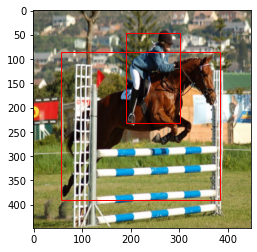

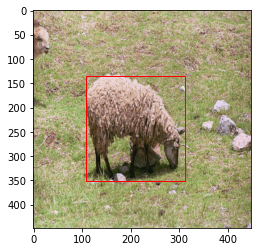

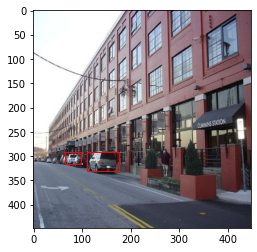

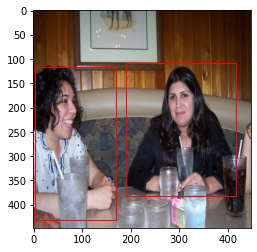

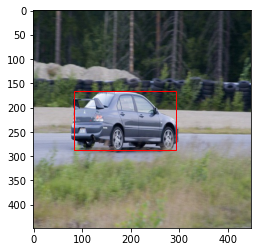

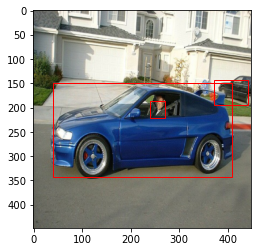

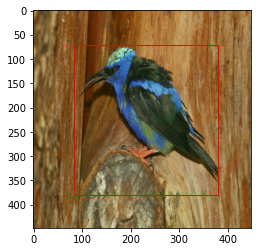

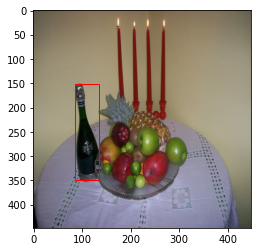

SystemExit: 

D:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3351: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [29]:
import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader
#from model import Yolov1
#from dataset import VOCDataset
#from utils import (
#    non_max_suppression,
#    mean_average_precision,
#    intersection_over_union,
#    cellboxes_to_boxes,
#    get_bboxes,
#    plot_image,
#    save_checkpoint,
#    load_checkpoint,
#)
#from loss import YoloLoss

seed = 123
torch.manual_seed(seed)

# Hyperparameters etc. 
LEARNING_RATE = 2e-5
DEVICE = "cpu"
BATCH_SIZE = 16 # 64 in original paper but I don't have that much vram, grad accum?
WEIGHT_DECAY = 0
EPOCHS = 500
NUM_WORKERS = 0
PIN_MEMORY = True
LOAD_MODEL = True
LOAD_MODEL_FILE = "overfit_detr1.pth.tar"
IMG_DIR = "D:\\deep learning specialization\\DETR\\PascalVOC dataset\\archive\\images"
LABEL_DIR = "D:\\deep learning specialization\\DETR\\PascalVOC dataset\\archive\\labels"


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])


def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())

    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")


def main():
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    loss_fn = YoloLoss()

    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    train_dataset = VOCDataset(
        "D:\\deep learning specialization\\DETR\\PascalVOC dataset\\archive\\100examples.csv",
        transform=transform,
        img_dir=IMG_DIR,
        label_dir=LABEL_DIR,
    )

    test_dataset = VOCDataset(
        "D:\\deep learning specialization\\DETR\\PascalVOC dataset\\archive\\test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,
    )

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

    for epoch in range(EPOCHS):
        for x, y in train_loader:
            x = x.to(DEVICE)
            for idx in range(8):
                bboxes = cellboxes_to_boxes(model(x))
                bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
                plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)

            import sys
            sys.exit()

        pred_boxes, target_boxes = get_bboxes(
            train_loader, model, iou_threshold=0.5, threshold=0.4
        )

        mean_avg_prec = mean_average_precision(
            pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
        )
        print('Epoch:', epoch, f"Train mAP: {mean_avg_prec}")

        if mean_avg_prec > 0.9:
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            }
            save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)
            import time
            time.sleep(10)

        train_fn(train_loader, model, optimizer, loss_fn)


if __name__ == "__main__":
    main()